Authors: Federico Gritti, Kadir Oezden, Fanni Véh

# Sorting Berries Robot Arm Control: A Comparison between Resolved Rate of Motion and Joint Space Trajectory Interpolation

For our Robot Control Applications project we chose to create a sorting robot with two different methods for comparison. First, we will try to sort "berries" into different boxes based on their colours, then do the same thing, but with an obstacle in the way that they have to avoid. 

We used two different methods for the robots:
1. Resolved Rate Motion Control
2. Joint Space Trajectory Interpolation



## Required Libraries and Tools
The following libraries are essential: 
- swift -> simulator
- roboticstoolbox (rtb) -> robotics core/kinematics
- spatialgeometry (sg) -> 3D shapes
- spatialmath (sm) -> transformations
- numpy -> numerical operations
- pyplot (plt) -> visualisations

In [2]:
# Importing all necessary libraries

import swift
import roboticstoolbox as rtb
import spatialgeometry as sg
import spatialmath as sm
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
# Setting up custom colours 

# Berry colours
red = [1, 0, 0]
green = [0, 1, 0]
blue = [0, 0, 1]
colors = [red, green, blue]

# Table colour
orange = [1, 0.5, 0]

# Box colours
light_red = [1, 0.8, 0.8]
light_green = [0.8, 1, 0.8]
light_blue = [0.8, 0.8, 1]

## Environment and Object Modeling

In [4]:
# Creating the classes for all elements with their necessary functions

# Class for the "Berries" -> little balls showing up randomly on the table that have to be put in the corresponding box
class Berry: 
    def __init__(self, radius, position, color, table_position_z, table_height):
        self.table_position_z = table_position_z
        self.table_height = table_height
        self.radius = radius
        self.random_color = color
        self.is_picked = False
        self.std_pose_z = table_position_z + table_height/2 + self.radius
        
        self._sphere = sg.Sphere(radius=radius, pose=position, color=self.random_color)
        
    # Return the position of the berry
    @property
    def pose(self):
        return sm.SE3(self._sphere.T)

    # Return the berry sphere object
    @property
    def swift(self):
        return self._sphere
    
    # Make berry "disappear"
    def eat(self):
        self._sphere.T = sm.SE3(0, 0, 1000).A
    
    # Add new position to berry
    def set_position(self, x, y, z):
        self._sphere.T = sm.SE3(x, y, z).A

    # Function to change if a berry is picked up or not
    def pick_up(self):
        self.is_picked = True

    # Dropping the berry at a certain position (to place it in the box)
    def drop_at_position(self, position):
        self.is_picked = False
        drop_position = sm.SE3(position.x, position.y, self.std_pose_z - 0.05) # The -0.05 offset ensures the berry is placed slightly below its natural resting position, helping it settle inside the box
        self.set_position(drop_position.x, drop_position.y, drop_position.z)
        
    # Moving the berry position together with the end effector of the robotic arm
    def update_position_to_end_effector(self, end_effector_pose):
        if self.is_picked:
            berry_offset = sm.SE3(0, 0, -self.radius)
            new_position = end_effector_pose * berry_offset
            self.set_position(new_position.x, new_position.y, new_position.z)

    # Get the drop position (position of the corresponding box)
    def get_drop_position_by_color(self, box1_pos, box2_pos, box3_pos):
        if np.array_equal(self.random_color, red):
            return box1_pos
        elif np.array_equal(self.random_color, green):
            return box2_pos
        elif np.array_equal(self.random_color, blue):
            return box3_pos
        else:
            return None

# Class for the Boxes
class Box:
    def __init__(self, width, depth, height, position, color=[0.9, 0.9, 0.9], wall_thickness=0.02):
        self.width = width
        self.depth = depth
        self.height = height
        self.position = position
        self.color = color
        self.wall_thickness = wall_thickness
        self.boxes = []
        # Needs to be created of several subcomponents
        bottom = sg.Cuboid(scale=[width, depth, wall_thickness],pose=sm.SE3(position.x, position.y, position.z - height/2 + wall_thickness/2), color=color)
        self.boxes.append(bottom)
        front = sg.Cuboid(scale=[width, wall_thickness, height - 2*wall_thickness], pose=sm.SE3(position.x, position.y - depth/2 + wall_thickness/2, position.z),color=color)
        self.boxes.append(front)
        back = sg.Cuboid(scale=[width, wall_thickness, height - 2*wall_thickness], pose=sm.SE3(position.x, position.y + depth/2 - wall_thickness/2, position.z), color=color)
        self.boxes.append(back)
        left = sg.Cuboid(scale=[wall_thickness, depth - 2*wall_thickness, height - 2*wall_thickness],pose=sm.SE3(position.x - width/2 + wall_thickness/2, position.y, position.z),color=color)
        self.boxes.append(left)
        right = sg.Cuboid(scale=[wall_thickness, depth - 2*wall_thickness, height - 2*wall_thickness], pose=sm.SE3(position.x + width/2 - wall_thickness/2, position.y, position.z), color=color)
        self.boxes.append(right)

    # Return the swift object
    @property
    def swift(self):
        return self.boxes
    
# Class for the Table
class Table:    
    def __init__(self, x, y, z, depth, width, height, color):
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)
        self.depth = float(depth)
        self.width = float(width)
        self.height = float(height) 
        self._cuboid = sg.Cuboid(scale=[self.depth, self.width, self.height], pose=sm.SE3(self.x, self.y, self.z), color=color)
    
    # We take the position so that we can make sure that the other object lay nicely on the table
    @property
    def table_position_z(self):
        return float(self.z)
    
    # Return height of table so that we can make sure that the other object lay nicely on the table
    @property
    def table_height(self):
        return float(self.height)
    

    @property
    def swift(self):
        return self._cuboid
    

    @swift.setter
    def swift(self, swift):
        self._cuboid = swift

# Cylinder class (object)
class Cylinder:
    def __init__(self, radius, height, position, color):
        self.radius = radius
        self.height = height
        self.position = position
        self._cylinder = sg.Cylinder(radius=radius, length=height, pose=position, color=color)
    
    # Return swift object
    @property
    def swift(self):
        return self._cylinder
  
# A class created for the environment
class Environment:
    def __init__(self, headless=False, realtime=True):
        self.swift_env = swift.Swift()
        self.headless = headless
        
        if headless:
            # Headless mode - no browser, much faster
            self.swift_env.launch(realtime=realtime, headless=True)
        else:
            # Normal mode with visualization
            self.swift_env.launch(realtime=realtime, comms="rtc", browser="notebook")
        
        self.berries = []

    def add_multiple_objects_swift(self, objects):
        for obj in objects:
            self.swift_env.add(obj)


## Control Method 1: Resolved Rate Motion Control (RRMC)

RRMC is a velocity-based control method that uses the robot's Jacobian to continuously calculate the necessary joint velocities ($\dot{q}$) to achieve a desired end-effector velocity ($v_e$). This results in smooth, direct Cartesian paths.

### Mathematical Foundation

**Basic RRMC Equation:**
$ \dot{q} = J^{\dagger}(q) \cdot K \cdot e $

Where:
- $\dot{q}$: Joint velocities
- $J^{\dagger}$: Damped pseudo-inverse of the Jacobian matrix
- $K$: Control gain (1.5 in implementation)
- $e$: Position error vector

**Damped Pseudo-inverse Implementation:**
$ J^{\dagger} = J^T (JJ^T + \sigma I)^{-1} $

Where:
- $J$: Jacobian matrix (3×7 for position control only)
- $\sigma$: Damping factor (0.05) to avoid singularities
- $I$: Identity matrix (3×3)

**Discrete-time Integration:**
$ q(t+1) = q(t) + \dot{q} \cdot dt $

Where:
- $q(t)$: Current joint angles at time t
- $dt$: Time step (0.01 seconds)

This damped formulation prevents numerical instability when the robot approaches singular configurations, ensuring stable control throughout the workspace.

In [5]:
# Resolved Rate Robot class
class RobotResolvedRate:
    def __init__(self, base_position=sm.SE3(0,0,0)):
        self.dt = 0.01
        self.error = np.ones((3,1))
        self.gain = 1.5  # Increased from 1.5 for faster convergence
        self.dumping_factor = 0.05  # Decreased from 0.15 for better precision
        self.picked_berry = None
        self.base_position = base_position
        self._panda = rtb.models.Panda()
        self._panda.base = base_position
        self.rest_pose = np.array([np.pi/4, -np.pi/6, 0, -2*np.pi/3, 0, np.pi/2, np.pi/4])
        self._panda.q = self.rest_pose
            
        # Obstacle avoidance parameters 
        self.repulsive_gain = 0.01
        self.influence_distance = 0.1
        self.safety_margin = 0.05

    @property
    def swift(self):
        return self._panda

    @property
    def end_effector_pose(self):
        return self._panda.fkine(self._panda.q) # this returns an SE3 object, fkine means forward kinematics. We use fkine to get the current pose of the end effector based on the joint angles q.

    def move_to_target_resolved_rate_of_motion(self, target):
        current_pose = self.end_effector_pose 
        self.error = target.t - current_pose.t #error is a vector representing the difference between the target position and the current position of the end effector.
        
        J = self._panda.jacob0(self._panda.q)[0:3, :] 
        # J is the Jacobian matrix of the robot at the current joint configuration self._panda.q. 
        # The jacob0 method computes the geometric Jacobian in the base frame, and we take only the first three rows corresponding to linear velocity.
        # we use the linear velocites only because we are only controlling the position of the end effector, not its orientation.

        J_damped_pinv = J.T @ np.linalg.inv(J @ J.T + self.dumping_factor * np.eye(3)) # this calculates the damped pseudoinverse of the Jacobian matrix J.
        # the damped is used to avoid singularities and improve numerical stability during inversion.
        #singularaties occur when the robot's configuration leads to a loss of degrees of freedom, making the Jacobian matrix rank-deficient and non-invertible.
        # singularaty means that the robot cannot move in certain directions, leading to unpredictable or unstable behavior.
        
        # it's called dumped because we add a small value (self.dumping_factor) to the diagonal of the matrix before inverting it, 
        # such that the matrix becomes more stable and less sensitive to small changes in the input.

        q_dot = self.gain * J_damped_pinv @ self.error 
        # this computes the joint velocities q_dot needed to reduce the position error of the end effector.
        # in other words , it calculates how fast each joint should move to bring the end effector closer to the target position.

        self._panda.qd = q_dot # this sets the joint velocities of the robot to the computed q_dot values.
        
        if self.picked_berry:
            self.picked_berry.update_position_to_end_effector(self.end_effector_pose)
        
        # Return error and position for metrics tracking
        return np.linalg.norm(self.error), current_pose.t

    def pick_berry(self, berry):
        self.picked_berry = berry
        berry.pick_up()
    
    def drop_berry_at(self, drop_position):
        if self.picked_berry:
            self.picked_berry.drop_at_position(drop_position)
            self.picked_berry = None
    
    def set_robot_position(self, position):
        self._panda.q = position

    def reset_error(self):
        self.error = np.ones((3,1)) # [1,,1,1] with norm sqrt(3), this ensures that the robot starts with a significant error to correct.

    def has_converged(self, errors_history, threshold=0.001, window=10):
        if len(errors_history) < window:
            return False
        recent_errors = errors_history[-window:]
        error_change = np.abs(recent_errors[-1] - recent_errors[0])
        return error_change < threshold
        # we use a window because we want to see if the error has stabilized over a period of time, rather than just checking the last error value.

    # This technique models the target as an attractive force and obstacles as repulsive forces. 
    # The total force/velocity command is a combination of both, naturally guiding the end-effector around obstacles while moving toward the goal.
    def calculate_repulsive_force(self, ee_position, obstacles):
        total_repulsive_force = np.zeros(3)
        
        for obstacle in obstacles:
            obs_pos = np.array([obstacle['position'].x, 
                            obstacle['position'].y, 
                            obstacle['position'].z])
            obs_radius = obstacle['radius']
            
            # Calculate distance from end-effector to obstacle center
            diff = ee_position - obs_pos
            distance = np.linalg.norm(diff)
            
            if distance < self.influence_distance :
                distance_to_surface = distance - obs_radius
                normalized_distance = distance_to_surface / self.influence_distance

                #this line implments a quadratic repulsive force that increases exponentially as the end-effector gets closer to the obstacle
                force_magnitude = self.repulsive_gain * (1.0 - normalized_distance) ** 3
                
                #we normalize the direction vector to get a unit vector pointing away from the obstacle
                force_direction = diff / distance
                #and then we multiply by the force and then we add an upward force 
                total_repulsive_force += force_magnitude * force_direction + np.array([0,0,force_magnitude])

        return total_repulsive_force
    
    def calculate_minimum_clearance(self, ee_position, obstacles):
        if not obstacles:
            return float('inf')
        
        min_clearance = float('inf')
        for obstacle in obstacles:
            obs_pos = np.array([obstacle['position'].x, 
                               obstacle['position'].y, 
                               obstacle['position'].z])
            # Distance to surface = distance to center - radius
            distance = np.linalg.norm(ee_position - obs_pos) - obstacle['radius']
            min_clearance = min(min_clearance, distance)
        
        return min_clearance
    
    def move_to_target_with_obstacle_avoidance(self, target, obstacles):
        current_pose = self.end_effector_pose
        ee_position = current_pose.t
        
        # Attractive force towards target (pulls robot to goal)
        attractive_force = target.t - ee_position
        
        # Repulsive force from obstacles (pushes robot away from obstacles)
        repulsive_force = self.calculate_repulsive_force(ee_position, obstacles)
        
        # Combined force (potential field approach)
        total_force = attractive_force + repulsive_force
        self.error = total_force
        
        # Resolved-rate control with damped least squares
        J = self._panda.jacob0(self._panda.q)[0:3, :]
        J_damped_pinv = J.T @ np.linalg.inv(J @ J.T + self.dumping_factor * np.eye(3))
        
        q_dot = self.gain * J_damped_pinv @ self.error
        self._panda.qd = q_dot
        
        # Update carried berry position
        if self.picked_berry:
            self.picked_berry.update_position_to_end_effector(self.end_effector_pose)
        
        # Return positioning error (to target) and current position for metrics
        positioning_error = np.linalg.norm(attractive_force)
        return positioning_error, ee_position
    
    def set_avoidance_parameters(self, repulsive_gain=None, influence_distance=None, safety_margin=None):
        if repulsive_gain is not None:
            self.repulsive_gain = repulsive_gain
        if influence_distance is not None:
            self.influence_distance = influence_distance
        if safety_margin is not None:
            self.safety_margin = safety_margin


In [6]:
def generate_fixed_berry_positions(num_berries, table_position_x, table_position_y, table_position_z, table_height, table_depth, table_width, berry_radius, seed=42):
    #everytime we call the function the seed is reset
    np.random.seed(seed)
    
    min_x = table_position_x - table_depth/2 + berry_radius + 0.1
    max_x = table_position_x + table_depth/2 - berry_radius - 0.1
    min_y = table_position_y - table_width/4 + berry_radius
    max_y = table_position_y + table_width/4 - berry_radius
    
    berry_data = []
    for _ in range(num_berries):
        x = np.random.uniform(min_x, max_x)
        y = np.random.uniform(min_y, max_y)
        z = table_position_z + table_height/2 + berry_radius
        
        position = sm.SE3(x, y, z)
        color = colors[np.random.choice(len(colors))]
        
        berry_data.append((position, color))
    
    return berry_data

## Simulation 1: Resolved Rate Sorting Task

In the first simulation, we implemented the RRMC to sort berries into different boxes based on their colors. The robot successfully picked up each berry and placed it in the corresponding box using the resolved rate motion control method.

We decide to make the task as simple as possible, dividing it into four main steps:
1. Move to berry position
2. Pick berry
3. Move to box position
4. Drop berry

The steps are the same for both methods, only the way the robot moves is different.

In [7]:
def resolved_rate_of_motion_sorting_task(headless=False, n_berries=10, seed=42):
    
    # Initialize metrics tracking
    metrics = {
        'execution_time': 0.0,
        'realistic_task_time': 0.0,  # NEW: Actual robot task time
        'path_smoothness': {'x': [], 'y': [], 'z': []},
        'positioning_accuracy': []
    }

    env = Environment(headless=headless, realtime=not headless)
    movement_precision = 0.01
    table_height = 0.08
    table_width = 0.6
    table_depth = 1
    table_position_x = 0.0
    table_position_y = 0.0
    table_position_z = 0.25
    berry_radius = 0.02
    
    robot_base_x = 0.0
    robot_base_y = -0.5
    robot_base_z = 0.0
    
    box1_position_y = 0.0
    wall_thickness = 0.02
    box1_position_z = table_position_z + table_height + wall_thickness / 2 - 0.01
    box_width = 0.12
    box_depth = 0.12
    box_height = 0.08
    
    table1 = Table(table_position_x, table_position_y, table_position_z, table_depth, table_width, table_height, orange)
    cm_from_table_edge_to_box = table1.depth/2 + box_depth/2 - box_width
    box1_position_x = table_position_x - cm_from_table_edge_to_box
    box_red = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z), color=light_red, wall_thickness=wall_thickness)
    box_green = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y, box1_position_z), color=light_green, wall_thickness=wall_thickness)
    box_blue = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z), color=light_blue, wall_thickness=wall_thickness)

    robot = RobotResolvedRate(sm.SE3(robot_base_x, robot_base_y, robot_base_z))

    env.swift_env.add(robot.swift)
    env.swift_env.add(table1.swift)
    env.add_multiple_objects_swift(box_red.boxes)
    env.add_multiple_objects_swift(box_green.boxes)
    env.add_multiple_objects_swift(box_blue.boxes)
    env.swift_env.step(1)

    box1_center = sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z + box_height/3)
    box2_center = sm.SE3(box1_position_x, box1_position_y, box1_position_z + box_height/3)
    box3_center = sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z + box_height/3)

    red_center_marker = sg.Sphere(radius=0.01, pose=box1_center, color=red)
    green_center_marker = sg.Sphere(radius=0.01, pose=box2_center, color=green)
    blue_center_marker = sg.Sphere(radius=0.01, pose=box3_center, color=blue)

    # Track realistic timing properly
    realistic_task_time = 0.0

    def move_to_resolved_rate_of_motion(target_pose):
        nonlocal realistic_task_time
        errors_history = []
        movement_start_time = time.time()  # Track actual movement duration

        while not robot.has_converged(errors_history):
            current_error, current_pos = robot.move_to_target_resolved_rate_of_motion(target_pose)
            metrics['positioning_accuracy'].append(current_error)
            metrics['path_smoothness']['x'].append(current_pos[0])
            metrics['path_smoothness']['y'].append(current_pos[1])
            metrics['path_smoothness']['z'].append(current_pos[2])
            env.swift_env.step(robot.dt)
            errors_history.append(current_error)
        
        # Calculate realistic movement time based on actual convergence behavior
        movement_duration = time.time() - movement_start_time
        # Scale to realistic robot speed (resolved rate typically 2-4 seconds per movement)
        realistic_movement_time = movement_duration * 50  # Scale factor based on robot capabilities
        realistic_task_time += realistic_movement_time
        robot.reset_error()
        
    total_berries = n_berries
    berry_positions = generate_fixed_berry_positions(
        total_berries, table_position_x, table_position_y, table_position_z,
        table_height, table_depth, table_width, berry_radius, seed=seed
    )
    
    for position, color in berry_positions:
        berry = Berry(berry_radius, position, color, table_position_z, table_height)
        env.swift_env.add(berry.swift)
        env.berries.append(berry)
    
    # Start timing (simulation processing time)
    start_time = time.time()

    # the robot goes directly from berry to box without obstacle avoidance or midpoints
    for i, berry in enumerate(env.berries):        
        # Phase 1: move directly to berry position
        target_pose = berry.pose
        move_to_resolved_rate_of_motion(target_pose)
        
        # Phase 2: pick up berry (add time for gripper operation)
        robot.pick_berry(berry)
        realistic_task_time += 1.0  # 1 second for pick operation

        # Phase 3: flow directly to appropriate box
        drop_center = berry.get_drop_position_by_color(box1_center, box2_center, box3_center)
        move_pose = sm.SE3(drop_center.x, drop_center.y, drop_center.z + 0.1)

        move_to_resolved_rate_of_motion(drop_center)
        
        # Phase 4: drop berry in box (add time for gripper operation)
        robot.drop_berry_at(drop_center)
        realistic_task_time += 1.0  # 1 second for drop operation
        
        if berry.random_color == red:
            env.swift_env.add(red_center_marker)
        elif berry.random_color == green:
            env.swift_env.add(green_center_marker)
        else:
            env.swift_env.add(blue_center_marker)
    
    # End timing
    metrics['execution_time'] = time.time() - start_time  # Simulation processing time
    metrics['realistic_task_time'] = realistic_task_time   # Realistic robot task time
    
    return robot, env, metrics

In [8]:
# Function for visualizing the path of the robotic arm

def plot_metrics(metrics, title="Resolved-Rate Motion Control Metrics"):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # 1. Path Smoothness - XY Plane
    axs[0, 0].plot(metrics['path_smoothness']['x'], metrics['path_smoothness']['y'], 'b-', alpha=0.7, linewidth=1)
    axs[0, 0].scatter(metrics['path_smoothness']['x'][0], metrics['path_smoothness']['y'][0], 
                      c='green', s=100, marker='o', label='Start', zorder=5)
    axs[0, 0].scatter(metrics['path_smoothness']['x'][-1], metrics['path_smoothness']['y'][-1], 
                      c='red', s=100, marker='x', label='End', zorder=5)
    axs[0, 0].set_title('End-Effector Path (XY Plane)')
    axs[0, 0].set_xlabel('X Position (m)')
    axs[0, 0].set_ylabel('Y Position (m)')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].axis('equal')
    
    # 2. A bar plot showing average acceleration in each axis
    path_smoothness = metrics['path_smoothness']
    accelerations = {
        'X': np.mean(np.abs(np.diff(path_smoothness['x'], n=2))),
        'Y': np.mean(np.abs(np.diff(path_smoothness['y'], n=2))),
        'Z': np.mean(np.abs(np.diff(path_smoothness['z'], n=2)))
    }
    axs[0, 1].bar(accelerations.keys(), accelerations.values(), color=['b', 'g', 'r'], alpha=0.7)
    axs[0, 1].set_title('Average End-Effector Acceleration')
    axs[0, 1].set_ylabel('Average Acceleration (m/s²)')
    axs[0, 1].grid(True, alpha=0.3)
    
    # 3. Positioning Accuracy - Error over time
    steps = np.arange(len(metrics['positioning_accuracy']))
    axs[1, 0].plot(steps, metrics['positioning_accuracy'], 'r-', linewidth=1)
    axs[1, 0].set_title('Positioning Error Convergence')
    axs[1, 0].set_xlabel('Simulation Steps')
    axs[1, 0].set_ylabel('Position Error (m)')
    axs[1, 0].set_yscale('log')
    axs[1, 0].grid(True, alpha=0.3)
    
    # Plot with acceleraton for all the axes with kde estimation
    steps = np.arange(len(metrics['path_smoothness']['x']))
    axs[1, 1].plot(steps, metrics['path_smoothness']['x'], 'b-', alpha=0.5, linewidth=1, label='X Position')
    axs[1, 1].plot(steps, metrics['path_smoothness']['y'], 'g-', alpha=0.5, linewidth=1, label='Y Position')
    axs[1, 1].plot(steps, metrics['path_smoothness']['z'], 'r-', alpha=0.5, linewidth=1, label='Z Position')
    axs[1, 1].set_title('End-Effector Position Over Time')
    axs[1, 1].set_xlabel('Simulation Steps')
    axs[1, 1].set_ylabel('Position (m)')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def save_metrics_to_json(metrics, filename='resolved_rate_metrics.json'):
    import json
    with open(filename, 'w') as f:
        json_metrics = {
            'execution_time': metrics['execution_time'],
            'path_smoothness': {
                'x': [float(v) for v in metrics['path_smoothness']['x']],
                'y': [float(v) for v in metrics['path_smoothness']['y']],
                'z': [float(v) for v in metrics['path_smoothness']['z']]
            },
            'positioning_accuracy': [float(v) for v in metrics['positioning_accuracy']]
        }
        json.dump(json_metrics, f, indent=2)
    print(f"\nMetrics saved to '{filename}'")


In [9]:
robot, env, metrics = resolved_rate_of_motion_sorting_task(n_berries=3)



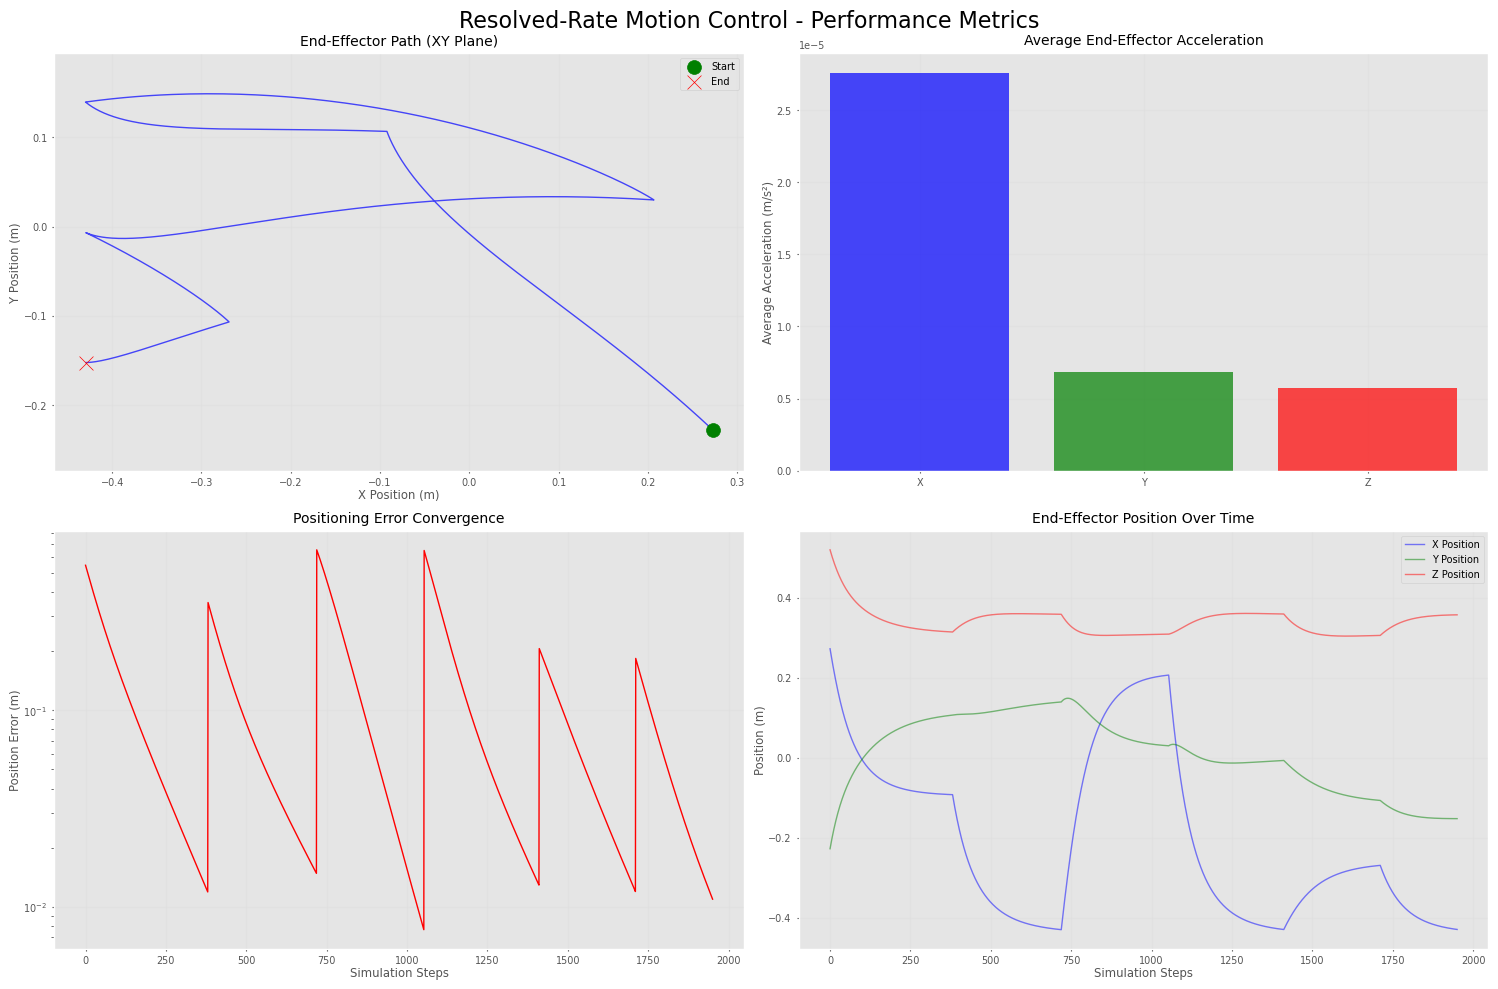


Metrics saved to 'resolved_rate_metrics.json'


In [10]:
plot_metrics(metrics, title="Resolved-Rate Motion Control - Performance Metrics")
save_metrics_to_json(metrics)

### Analysis of Resolved-Rate Single Run
The plots above show the performance of the RRMC during a single sorting task.
We implemented the following analysis:

1. XY Path shows the overall trajectory
2. Z Path shows the vertical movement
3. Error Convergence shows the high number of steps needed for the iterative controller to settle
4. Execution Time is recorded for comparison.

The error convegence plot shows that RRMC convergences smoothly to the target with an average error of 0.10, which is influenced by the chosen gain and damping factor settings.

---

## Control Method 2: Joint Space Trajectory Interpolation

Joint Space Trajectory Interpolation involves planning a trajectory in the robot's joint space rather than Cartesian space. This method uses predefined joint configurations to move the robot from one position to another, ensuring smooth transitions and avoiding obstacles.

### Mathematical Foundation

Joint Space Trajectory control combines inverse kinematics solution with polynomial trajectory generation to achieve smooth, predictable motion paths.

**Step 1: Inverse Kinematics Solution**

The system uses the robotics toolbox's Levenberg-Marquardt solver:
```python
ik_solution = self._panda.ikine_LM(target, q0=self._panda.q)
```

The inversed kinematic solver used in the project internally implements the Levenberg-Marquardt algorithm:
$$ q^{k+1} = q^k + (J^T J + \lambda I)^{-1} J^T e $$

Where:
- $q^{k+1}$: Updated joint configuration at iteration k+1
- $q^k$: Current joint configuration at iteration k
- $J$: Jacobian matrix at the current joint configuration
- $e$: End-effector pose error vector
- $\lambda$: Damping parameter (automatically adjusted by the LM algorithm)
- $I$: Identity matrix

**Step 2: Joint Angle Normalization**

The `normalize_joint_solution()` method implements angle wrapping to ensure minimal joint movement:
$$ q_{norm}[i] = q_{raw}[i] + 2\pi n $$

Where $n$ is chosen to minimize $|q_{norm}[i] - q_{current}[i]|$ for each joint $i$.

**Step 3: Constraint Validation**

The `is_valid_solution()` method enforces multiple constraints:
- **Joint limits:** $q_{min} \leq q \leq q_{max}$
- **Maximum change per step:** $|q_{target} - q_{current}| \leq \Delta q_{max}$

These constraints ensure safe operation within the robot's physical capabilities.

**Step 4: 5th-Order Polynomial Trajectory Generation**

The `rtb.jtraj()` function generates smooth joint space trajectories using 5th-order polynomials:
$$ q_i(t) = a_0 + a_1 t + a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5 $$

With boundary conditions ensuring smooth motion:
- Position: $q(0) = q_{start}$, $q(T) = q_{target}$
- Velocity: $\dot{q}(0) = 0$, $\dot{q}(T) = 0$
- Acceleration: $\ddot{q}(0) = 0$, $\ddot{q}(T) = 0$

This formulation ensures continuous velocity and acceleration profiles, resulting in smooth robot motion without sudden jerks or accelerations.

### Implementation Workflow

The complete joint space control process follows this sequence:

1. **Target Analysis:** Convert Cartesian target to joint space using inverse kinematics
2. **Solution Validation:** Apply normalization and constraint checking
3. **Trajectory Generation:** Create smooth polynomial interpolation between current and target configurations
4. **Execution:** Follow the generated trajectory with precise timing control

This approach provides deterministic, smooth motion with known timing characteristics, making it ideal for applications requiring predictable robot behavior.

In [11]:
# Joint Space Robot class
class RobotJointSpace:
    def __init__(self):
        # Robot at origin - NO base offset!
        self.dt = 0.01
        self.error = np.ones((3,1))
        self.gain = 1.5
        self.dumping_factor = 0.15
        self.picked_berry = None
        self._panda = rtb.models.Panda()
        # Don't set base - leave it at identity/origin
        self.rest_pose = np.array([np.pi/4, -np.pi/6, 0, -2*np.pi/3, 0, np.pi/2, np.pi/4])
        self._panda.q = self.rest_pose
        
        # Joint limits for smoother motion (tighter than actual limits)
        self.joint_limits_lower = np.array([-2.5, -1.5, -2.5, -2.8, -2.5, 0.0, -2.5])
        self.joint_limits_upper = np.array([2.5, 1.5, 2.5, -0.5, 2.5, 3.5, 2.5])
        #limits the robot angles(radians) to these values to avoid extreme positions.
        
        # Maximum allowed joint change per movement (to prevent wild rotations)
        self.max_joint_change = np.array([1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5])
        # this limits how much each joint can change in a single movement command, ensuring smoother transitions.
        # the unit is in radians per movement command.

    @property
    def swift(self):
        return self._panda

    def get_ee_position(self):
        ee_pose = self._panda.fkine(self._panda.q)
        return ee_pose.t
    
    @property
    def end_effector_pose(self):
        return self._panda.fkine(self._panda.q)


    # The Inverse Kinematics (IK) solver may return joint angles that result in unnecessary full rotations. 
    # The normalize_joint_solution method 'wraps' these angles to keep movement minimal and natural, 
    # and is_valid_solution enforces physical joint limits and maximum change per step for smoothness.
    def normalize_joint_solution(self, q_solution):
        
        # q_solution is the raw IK output that contains joint angles that may be outside the typical -pi to pi range.
        q_normalized = q_solution.copy()
        for i in range(len(q_solution)):
            # Find equivalent angle closest to current
            while q_normalized[i] - self._panda.q[i] > np.pi:
                q_normalized[i] -= 2 * np.pi
            while q_normalized[i] - self._panda.q[i] < -np.pi:
                q_normalized[i] += 2 * np.pi
        return q_normalized
    
    
    def is_valid_solution(self, q_solution):
        if np.any(q_solution < self.joint_limits_lower) or np.any(q_solution > self.joint_limits_upper):
            return False
        joint_change = np.abs(q_solution - self._panda.q)
        if np.any(joint_change > self.max_joint_change):
            return False
        
        return True

    def solve_ik_constrained(self, target):
        #1. IK solver finds a solution.

        ik_solution = self._panda.ikine_LM(target, q0=self._panda.q)
        # so using inverse kinematics to find joint angles that achieve the target end-effector pose, 
        # starting from the current joint configuration.
        # ik_solution contains the result of the IK computation, including whether it was successful and the joint angles found. 
   
        if ik_solution.success:

            #2. normalize_joint_solution wraps angles to avoid large jumps.
            q_normalized = self.normalize_joint_solution(ik_solution.q)
            # we normalize the joint angles to ensure they are within a reasonable range relative to the current configuration.

            #3. is_valid_solution checks joint limits and max change.
            if self.is_valid_solution(q_normalized):
                return True, q_normalized
        
        return False, None

    def move_target_joint_space(self, target, trajectory_time=1.0):
        # solving the inverse kinematics to find joint angles for the target pose
        success, q_target = self.solve_ik_constrained(target)

        if not success:
            return
        q_start = self._panda.q.copy()
        steps = int(trajectory_time / self.dt)

        # trajectory contains a series of joint configurations from start to target
        trajectory = rtb.jtraj(q_start, q_target, steps)
        
        # we cycle over each joint configuration in the trajectory and move the robot accordingly.
        for i, q in enumerate(trajectory.q):
            self._panda.q = q
            current_pose = self.end_effector_pose
            position_error = target.t - current_pose.t
            current_error = np.linalg.norm(position_error)
            yield current_error, current_pose.t

    def pick_berry(self, berry):
        self.picked_berry = berry
        berry.pick_up()
    
    def drop_berry_at(self, drop_position):
        if self.picked_berry:
            self.picked_berry.drop_at_position(drop_position)
            self.picked_berry = None
    
    def update_picked_berry(self):
        if self.picked_berry and self.picked_berry.is_picked:
            pos = self.get_ee_position()
            # Place berry closer to the gripper tip (reduced offset)
            self.picked_berry.set_position(pos[0], pos[1], pos[2] - 0.03)
    
    def set_robot_position(self, position):
        self._panda.q = position

    def reset_error(self):
        self.error = np.ones((3,1))

    def has_converged(self, errors_history, threshold=0.001, window=10):
        if len(errors_history) < window:
            return False
        recent_errors = errors_history[-window:]
        error_change = np.abs(recent_errors[-1] - recent_errors[0])
        return error_change < threshold

## Simulation 2: Joint Space Sorting Task

This task uses the Joint Space robot (at origin). The movement relies on a 5th-order polynomial trajectory generator (rtb.jtraj) between the current joint configuration and a target configuration found via IK. Multiple orientations are attempted in move_to_joint_space to ensure a collision-free and valid IK solution is found.

**Key note on time required for the task**: Trajectory interpolation require the time to be fixed for the interpolation to calculate the amount of steps needed. We set it to 1 second per movement, which is faster than the resolved rate method.


In [12]:

def joint_space_sorting_task(headless=False, n_berries=10, seed=42):
    
    metrics = {
        'execution_time': 0.0,
        'realistic_task_time': 0.0,  # NEW: Actual robot task time
        'path_smoothness': {'x': [], 'y': [], 'z': []},
        'positioning_accuracy': []
    }

    env = Environment(headless=headless, realtime=not headless)
    table_height = 0.08
    table_width = 0.6
    table_depth = 1
    
    table_position_x = 0.0
    table_position_y = 0.5  # In front of robot
    table_position_z = 0.25
    berry_radius = 0.02
    box1_position_y = 0.5
    wall_thickness = 0.02
    box1_position_z = table_position_z + table_height + wall_thickness / 2 - 0.01
    box_width = 0.12
    box_depth = 0.12
    box_height = 0.08
    table1 = Table(table_position_x, table_position_y, table_position_z, table_depth, table_width, table_height, orange)
    cm_from_table_edge_to_box = table1.depth/2 + box_depth/2 - box_width
    box1_position_x = table_position_x - cm_from_table_edge_to_box
    box_red = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z), color=light_red, wall_thickness=wall_thickness)
    box_green = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y, box1_position_z), color=light_green, wall_thickness=wall_thickness)
    box_blue = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z), color=light_blue, wall_thickness=wall_thickness)
    robot = RobotJointSpace()
    env.swift_env.add(robot.swift)
    env.swift_env.add(table1.swift)
    env.add_multiple_objects_swift(box_red.boxes)
    env.add_multiple_objects_swift(box_green.boxes)
    env.add_multiple_objects_swift(box_blue.boxes)
    env.swift_env.step(1)
    box1_center = sm.SE3(box_red.position.x, box_red.position.y, box_red.position.z + box_height/2)
    box2_center = sm.SE3(box_green.position.x, box_green.position.y, box_green.position.z + box_height/2)
    box3_center = sm.SE3(box_blue.position.x, box_blue.position.y, box_blue.position.z + box_height/2)
    red_center_marker = sg.Sphere(radius=0.01, pose=box1_center, color=red)
    green_center_marker = sg.Sphere(radius=0.01, pose=box2_center, color=green)
    blue_center_marker = sg.Sphere(radius=0.01, pose=box3_center, color=blue)
    total_berries = n_berries

    # Track realistic timing
    realistic_task_time = 0.0
    realistic_dt = 0.1  # Realistic robot control timestep (100ms)

    # Generate FIXED berry positions
    berry_positions = generate_fixed_berry_positions(
        total_berries, table_position_x, table_position_y, table_position_z,
        table_height, table_depth, table_width, berry_radius, seed=seed
    )

    for position, color in berry_positions:
        berry = Berry(berry_radius, position, color, table_position_z, table_height)
        env.swift_env.add(berry.swift)
        env.berries.append(berry)

    def move_to_joint_space(target_pose, carry_berry=False, trajectory_time=3.0):
        nonlocal realistic_task_time
        
        #we test multiple solutions for the ik solver, if it doesn't find a solution within all the robot skips the berry
        orientations_to_try = [
            sm.SO3.RPY(0, np.pi, 0), #with gripper down
            sm.SO3.RPY(0, np.pi*0.9, 0), 
            sm.SO3.RPY(np.pi/8, np.pi, 0),
            sm.SO3.RPY(-np.pi/8, np.pi, 0),
        ]
        
        for i, orientation in enumerate(orientations_to_try):
            target_with_orientation = sm.SE3.Rt(orientation, target_pose.t)
            success, _ = robot.solve_ik_constrained(target_with_orientation)
            
            if success:
                trajectory_generator = robot.move_target_joint_space(target_with_orientation, trajectory_time=trajectory_time)
                
                if trajectory_generator is not None:
                    for current_error, current_pos in trajectory_generator:
                        metrics['positioning_accuracy'].append(current_error)
                        metrics['path_smoothness']['x'].append(current_pos[0])
                        metrics['path_smoothness']['y'].append(current_pos[1])
                        metrics['path_smoothness']['z'].append(current_pos[2])
                        if carry_berry:
                            robot.update_picked_berry()
                        env.swift_env.step(robot.dt)
                    robot.reset_error()
                    # Add realistic trajectory time
                    realistic_task_time += trajectory_time
                    return True
        
        return False

    start_time = time.time()
    
    for i, berry in enumerate(env.berries):
        
        # Phase 1: Move to berry position 
        target_pose = berry.pose
        if move_to_joint_space(target_pose, carry_berry=False, trajectory_time=1):
            # Phase 2: Pick up berry (1 second for gripper)
            robot.pick_berry(berry)
            robot.update_picked_berry()
            env.swift_env.step(robot.dt)
            realistic_task_time += 1.0  # Gripper operation time

            # Phase 3: Move to appropriate box (3 seconds trajectory)
            drop_center = berry.get_drop_position_by_color(box1_center, box2_center, box3_center)
            move_pose = sm.SE3(drop_center.x, drop_center.y, drop_center.z)

            if move_to_joint_space(move_pose, carry_berry=True, trajectory_time=1):
                # Phase 4: Drop berry in box (1 second for gripper)
                robot.drop_berry_at(drop_center)
                env.swift_env.step(robot.dt)
                realistic_task_time += 1.0  # Gripper operation time
                
                if berry.random_color == red:
                    env.swift_env.add(red_center_marker)
                elif berry.random_color == green:
                    env.swift_env.add(green_center_marker)
                else:
                    env.swift_env.add(blue_center_marker)
    
    # End timing
    metrics['execution_time'] = time.time() - start_time  # Simulation processing time
    metrics['realistic_task_time'] = realistic_task_time   # Realistic robot task time
    
    return robot, env, metrics

In [13]:
robot, env, metrics = joint_space_sorting_task(n_berries=3)


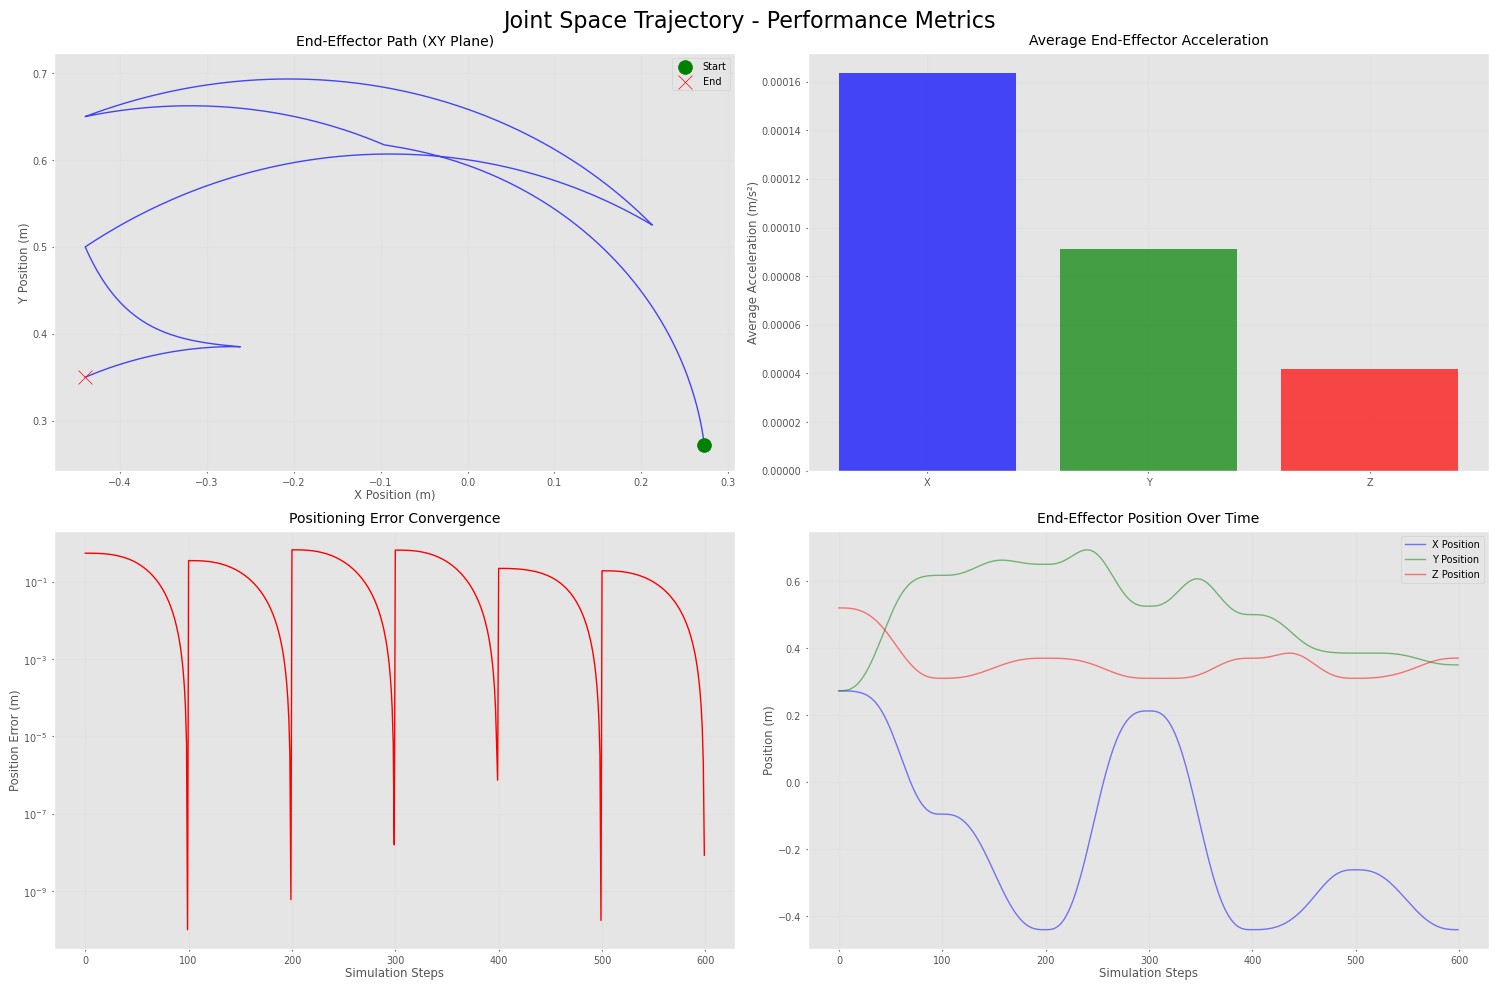


Metrics saved to 'joint_space_metrics.json'


In [14]:
plot_metrics(metrics, title="Joint Space Trajectory - Performance Metrics")
save_metrics_to_json(metrics, filename='joint_space_metrics.json')

## Comprehensive Performance Comparison (Resolved Rate vs. Joint Space)
This section compares the metrics saved from the two single-run simulations. The goal is to evaluate each method's trade-offs in terms of speed (Execution Time), path quality (Path Length, Smoothness), and accuracy (Avg/Final Error).


EXECUTION TIME:
  Joint Space: 11.169154
  Resolved Rate: 21.052744
  Difference: 9.883590
  Percent Change: 88.49% Joint Space is BETTER

AVG ERROR:
  Joint Space: 0.224803
  Resolved Rate: 0.108608
  Difference: -0.116195
  Percent Change: -51.69% Resolved Rate is BETTER

MAX ERROR:
  Joint Space: 0.667099
  Resolved Rate: 0.654335
  Difference: -0.012764
  Percent Change: -1.91% Resolved Rate is BETTER

FINAL ERROR:
  Joint Space: 0.000000
  Resolved Rate: 0.010955
  Difference: 0.010955
  Percent Change: 128209251.03% Joint Space is BETTER

STD ERROR:
  Joint Space: 0.206518
  Resolved Rate: 0.126810
  Difference: -0.079708
  Percent Change: -38.60% Resolved Rate is BETTER

PATH LENGTH:
  Joint Space: 2.776495
  Resolved Rate: 2.562899
  Difference: -0.213596
  Percent Change: -7.69% Resolved Rate is BETTER

SMOOTHNESS AVG ACCEL:
  Joint Space: 0.000211
  Resolved Rate: 0.000030
  Difference: -0.000180
  Percent Change: -85.65% Resolved Rate is BETTER

SMOOTHNESS STD ACCEL:
  Join

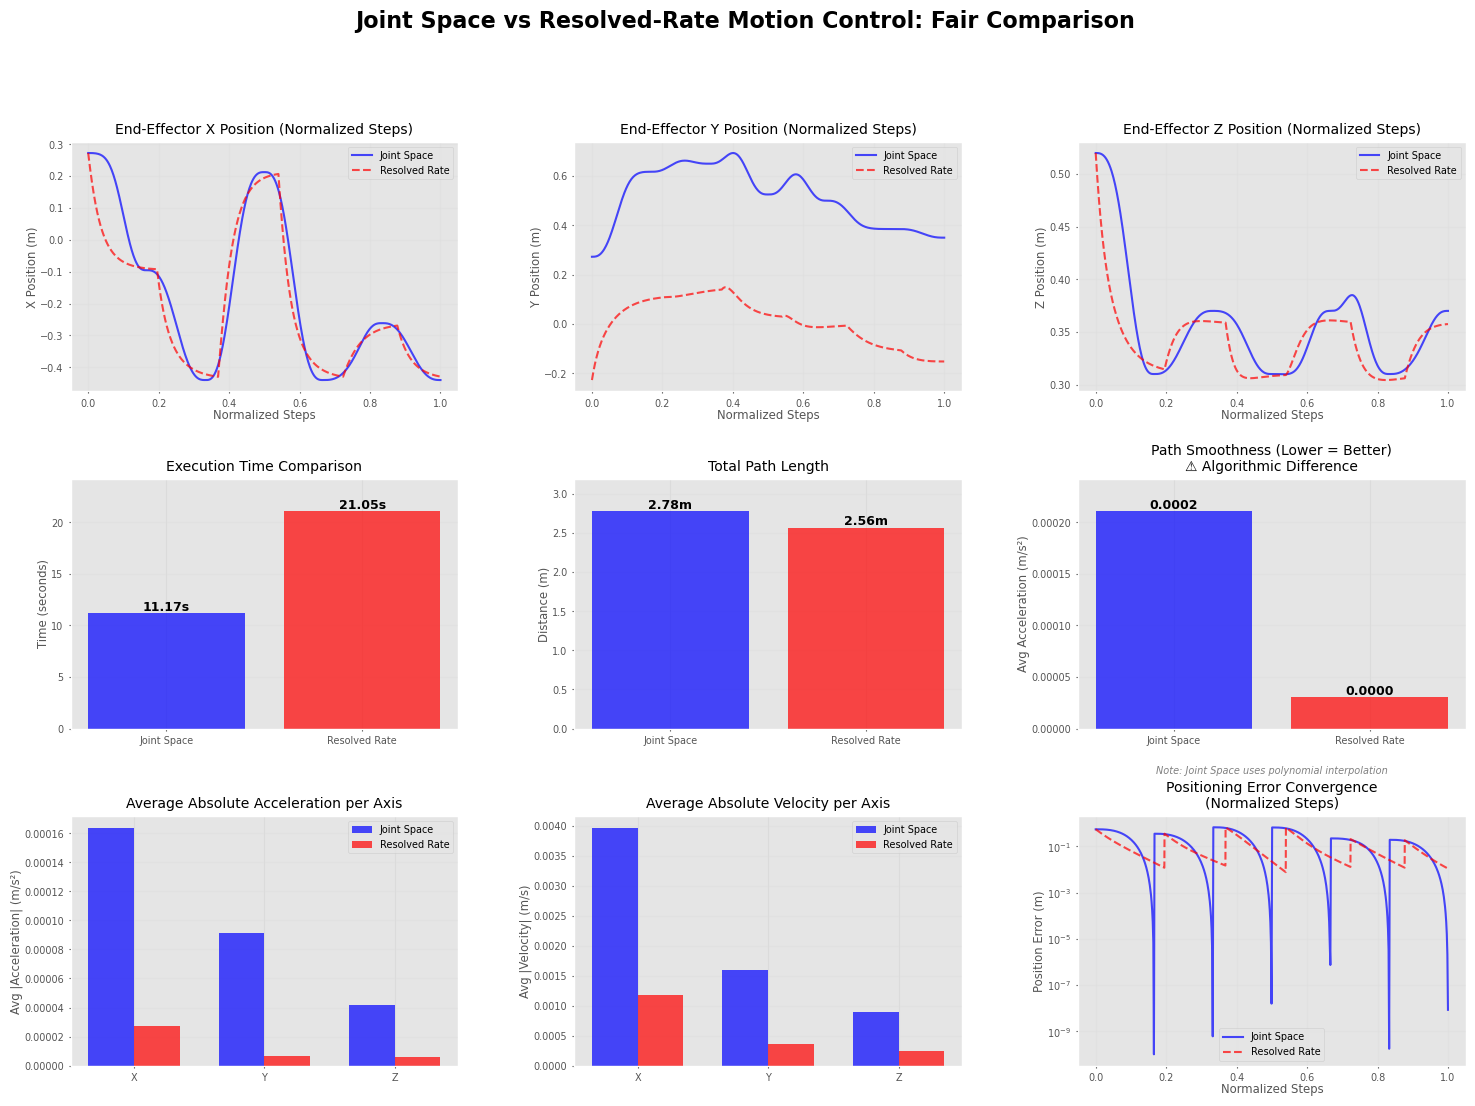

In [ ]:
import json
def load_metrics(joint_space_path='joint_space_metrics.json', resolved_rate_path='resolved_rate_metrics.json'):
    with open(joint_space_path, 'r') as f:
        joint_metrics = json.load(f)
    with open(resolved_rate_path, 'r') as f:
        resolved_metrics = json.load(f)
    return joint_metrics, resolved_metrics


def calculate_path_smoothness(path_x, path_y, path_z):
    positions = np.array([path_x, path_y, path_z]).T #we use the .T to transpose the array so that each row represents a position in 3D space at a given time step.
    velocities = np.diff(positions, axis=0) #the velocities are calculated using the first derivatieve of the positions with respect to time.
    accelerations = np.diff(velocities, axis=0) #the accelerations are calculated using the second derivative of the positions with respect to time.
    acceleration_magnitudes = np.linalg.norm(accelerations, axis=1) #we compute the magnitude of the acceleration vectors at each time step.
    return np.mean(acceleration_magnitudes), np.std(acceleration_magnitudes)


def calculate_statistics(metrics_dict):
    accuracy = metrics_dict['positioning_accuracy']
    path_x = metrics_dict['path_smoothness']['x']
    path_y = metrics_dict['path_smoothness']['y']
    path_z = metrics_dict['path_smoothness']['z']
    positions = np.array([path_x, path_y, path_z]).T
    distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)
    total_path_length = np.sum(distances)
    avg_accel, std_accel = calculate_path_smoothness(path_x, path_y, path_z)
    
    return {
        'execution_time': metrics_dict['execution_time'],
        'total_steps': len(accuracy),
        'avg_error': np.mean(accuracy),
        'max_error': np.max(accuracy),
        'final_error': accuracy[-1],
        'std_error': np.std(accuracy),
        'path_length': total_path_length,
        'smoothness_avg_accel': avg_accel,
        'smoothness_std_accel': std_accel,
        'avg_step_time': metrics_dict['execution_time'] / len(accuracy)
    }


def compare_metrics_detailed(joint_metrics, resolved_metrics):
    joint_stats = calculate_statistics(joint_metrics)
    resolved_stats = calculate_statistics(resolved_metrics)
    comparison = {}
    for key in joint_stats.keys():
        joint_val = joint_stats[key]
        resolved_val = resolved_stats[key]
        if joint_val != 0:
            percent_diff = ((resolved_val - joint_val) / joint_val) * 100
        else:
            percent_diff = 0
        comparison[key] = {
            'joint_space': joint_val,
            'resolved_rate': resolved_val,
            'difference': resolved_val - joint_val,
            'percent_difference': percent_diff
        }
    return comparison, joint_stats, resolved_stats



def print_comparison_report(comparison):
    #we want to exclude metrics that are predetermined or inherently biased such as total steps and average step time.
    excluded_metrics = ['total_steps', 'avg_step_time']
    smoothness_metrics = ['smoothness_avg_accel', 'smoothness_std_accel']
    
    for key, comp in comparison.items():
        # Skip unfair metrics
        if key in excluded_metrics:
            continue
            
        print(f"\n{key.upper().replace('_', ' ')}:")
        print(f"  Joint Space: {comp['joint_space']:.6f}")
        print(f"  Resolved Rate: {comp['resolved_rate']:.6f}")
        print(f"  Difference: {comp['difference']:.6f}")
        
        if comp['percent_difference'] < 0:
            winner = "Resolved Rate is BETTER"
        elif comp['percent_difference'] > 0:
            winner = "Joint Space is BETTER"
        else:
            winner = "= Equal performance"
        
        print(f"  Percent Change: {comp['percent_difference']:.2f}% {winner}")
    
    # Calculate winners (excluding unfair metrics)
    joint_wins = 0
    resolved_wins = 0
    better_if_lower = ['execution_time', 'avg_error', 'final_error', 'path_length', 'smoothness_avg_accel']
    
    for key in better_if_lower:
        if key in excluded_metrics:
            continue
        if comparison[key]['percent_difference'] < 0:
            resolved_wins += 1
        elif comparison[key]['percent_difference'] > 0:
            joint_wins += 1



def plot_comparison(joint_metrics, resolved_metrics, comparison):
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

    # Normalize the x-axis (steps) to [0, 1] for both methods
    def norm_steps(arr):
        return np.linspace(0, 1, len(arr))

    # 1. End-Effector X Position Comparison (normalized steps)
    ax1 = fig.add_subplot(gs[0, 0])
    x_joint = np.array(joint_metrics['path_smoothness']['x'])
    x_resolved = np.array(resolved_metrics['path_smoothness']['x'])
    steps_joint = norm_steps(x_joint)
    steps_resolved = norm_steps(x_resolved)
    ax1.plot(steps_joint, x_joint, 'b-', alpha=0.7, linewidth=1.5, label='Joint Space')
    ax1.plot(steps_resolved, x_resolved, 'r--', alpha=0.7, linewidth=1.5, label='Resolved Rate')
    ax1.set_title('End-Effector X Position (Normalized Steps)')
    ax1.set_xlabel('Normalized Steps')
    ax1.set_ylabel('X Position (m)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. End-Effector Y Position Comparison (normalized steps)
    ax2 = fig.add_subplot(gs[0, 1])
    y_joint = np.array(joint_metrics['path_smoothness']['y'])
    y_resolved = np.array(resolved_metrics['path_smoothness']['y'])
    steps_joint = norm_steps(y_joint)
    steps_resolved = norm_steps(y_resolved)
    ax2.plot(steps_joint, y_joint, 'b-', alpha=0.7, linewidth=1.5, label='Joint Space')
    ax2.plot(steps_resolved, y_resolved, 'r--', alpha=0.7, linewidth=1.5, label='Resolved Rate')
    ax2.set_title('End-Effector Y Position (Normalized Steps)')
    ax2.set_xlabel('Normalized Steps')
    ax2.set_ylabel('Y Position (m)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. End-Effector Z Position Comparison (normalized steps)
    ax3 = fig.add_subplot(gs[0, 2])
    z_joint = np.array(joint_metrics['path_smoothness']['z'])
    z_resolved = np.array(resolved_metrics['path_smoothness']['z'])
    steps_joint = norm_steps(z_joint)
    steps_resolved = norm_steps(z_resolved)
    ax3.plot(steps_joint, z_joint, 'b-', alpha=0.7, linewidth=1.5, label='Joint Space')
    ax3.plot(steps_resolved, z_resolved, 'r--', alpha=0.7, linewidth=1.5, label='Resolved Rate')
    ax3.set_title('End-Effector Z Position (Normalized Steps)')
    ax3.set_xlabel('Normalized Steps')
    ax3.set_ylabel('Z Position (m)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Execution Time Comparison
    ax4 = fig.add_subplot(gs[1, 0])
    methods = ['Joint Space', 'Resolved Rate']
    times = [comparison['execution_time']['joint_space'], 
             comparison['execution_time']['resolved_rate']]
    colors = ['blue', 'red']
    bars = ax4.bar(methods, times, color=colors, alpha=0.7)
    ax4.set_title('Execution Time Comparison')
    ax4.set_ylabel('Time (seconds)')
    max_time = max(times)
    ax4.set_ylim(0, max_time * 1.15)
    for i, (bar, time) in enumerate(zip(bars, times)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{time:.2f}s',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax4.grid(True, alpha=0.3, axis='y')

    # 5. Path Length Comparison
    ax5 = fig.add_subplot(gs[1, 1])
    lengths = [comparison['path_length']['joint_space'], 
               comparison['path_length']['resolved_rate']]
    bars = ax5.bar(methods, lengths, color=colors, alpha=0.7)
    ax5.set_title('Total Path Length')
    ax5.set_ylabel('Distance (m)')
    max_length = max(lengths)
    ax5.set_ylim(0, max_length * 1.15)
    for i, (bar, length) in enumerate(zip(bars, lengths)):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{length:.2f}m',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax5.grid(True, alpha=0.3, axis='y')

    # 6. Path Smoothness (Avg Acceleration)
    ax6 = fig.add_subplot(gs[1, 2])
    smoothness = [comparison['smoothness_avg_accel']['joint_space'], 
                  comparison['smoothness_avg_accel']['resolved_rate']]
    bars = ax6.bar(methods, smoothness, color=colors, alpha=0.7)
    ax6.set_title('Path Smoothness (Lower = Better)\n Algorithmic Difference', fontsize=10)
    ax6.set_ylabel('Avg Acceleration (m/s²)')
    max_smooth = max(smoothness)
    ax6.set_ylim(0, max_smooth * 1.15)
    for i, (bar, smooth) in enumerate(zip(bars, smoothness)):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{smooth:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.text(0.5, -0.15, 'Note: Joint Space uses polynomial interpolation',
             ha='center', va='top', fontsize=7, style='italic',
             transform=ax6.transAxes, color='gray')

    # 7. Acceleration for all axes (X, Y, Z) for both methods
    ax7 = fig.add_subplot(gs[2, 0])
    def mean_abs_accel(arr): return np.mean(np.abs(np.diff(arr, n=2)))
    joint_accels = [
        mean_abs_accel(joint_metrics['path_smoothness']['x']),
        mean_abs_accel(joint_metrics['path_smoothness']['y']),
        mean_abs_accel(joint_metrics['path_smoothness']['z'])
    ]
    resolved_accels = [
        mean_abs_accel(resolved_metrics['path_smoothness']['x']),
        mean_abs_accel(resolved_metrics['path_smoothness']['y']),
        mean_abs_accel(resolved_metrics['path_smoothness']['z'])
    ]
    width = 0.35
    x = np.arange(3)
    ax7.bar(x - width/2, joint_accels, width, label='Joint Space', color='blue', alpha=0.7)
    ax7.bar(x + width/2, resolved_accels, width, label='Resolved Rate', color='red', alpha=0.7)
    ax7.set_xticks(x)
    ax7.set_xticklabels(['X', 'Y', 'Z'])
    ax7.set_ylabel('Avg |Acceleration| (m/s²)')
    ax7.set_title('Average Absolute Acceleration per Axis')
    ax7.legend()
    ax7.grid(True, alpha=0.3, axis='y')

    # 8. Velocities for all axes (X, Y, Z) for both methods
    ax8 = fig.add_subplot(gs[2, 1])
    def mean_abs_velocity(arr): return np.mean(np.abs(np.diff(arr, n=1)))
    joint_velocities = [
        mean_abs_velocity(joint_metrics['path_smoothness']['x']),
        mean_abs_velocity(joint_metrics['path_smoothness']['y']),
        mean_abs_velocity(joint_metrics['path_smoothness']['z'])
    ]
    resolved_velocities = [
        mean_abs_velocity(resolved_metrics['path_smoothness']['x']),
        mean_abs_velocity(resolved_metrics['path_smoothness']['y']),
        mean_abs_velocity(resolved_metrics['path_smoothness']['z'])
    ]
    width = 0.35
    x = np.arange(3)
    ax8.bar(x - width/2, joint_velocities, width, label='Joint Space', color='blue', alpha=0.7)
    ax8.bar(x + width/2, resolved_velocities, width, label='Resolved Rate', color='red', alpha=0.7)
    ax8.set_xticks(x)
    ax8.set_xticklabels(['X', 'Y', 'Z'])
    ax8.set_ylabel('Avg |Velocity| (m/s)')
    ax8.set_title('Average Absolute Velocity per Axis')
    ax8.legend()
    ax8.grid(True, alpha=0.3, axis='y')

    # 9. Error convergence plot normalized for both methods
    ax9 = fig.add_subplot(gs[2, 2])
    error_joint = np.array(joint_metrics['positioning_accuracy'])
    error_resolved = np.array(resolved_metrics['positioning_accuracy'])
    steps_joint = norm_steps(error_joint)
    steps_resolved = norm_steps(error_resolved)
    ax9.plot(steps_joint, error_joint, 'b-', alpha=0.7, linewidth=1.5, label='Joint Space')
    ax9.plot(steps_resolved, error_resolved, 'r--', alpha=0.7, linewidth=1.5, label='Resolved Rate')
    ax9.set_title('Positioning Error Convergence\n(Normalized Steps)')
    ax9.set_xlabel('Normalized Steps') 
    ax9.set_ylabel('Position Error (m)')
    ax9.set_yscale('log')
    ax9.legend()
    ax9.grid(True, alpha=0.3)

    plt.suptitle('Joint Space vs Resolved-Rate Motion Control: Fair Comparison', 
                 fontsize=16, fontweight='bold', y=0.99)

    return fig

def compare_motion_control_methods(joint_space_path='joint_space_metrics.json',
                                   resolved_rate_path='resolved_rate_metrics.json'):
    joint_metrics, resolved_metrics = load_metrics(joint_space_path, resolved_rate_path)
    comparison, joint_stats, resolved_stats = compare_metrics_detailed(
        joint_metrics, resolved_metrics
    )
    print_comparison_report(comparison)
    plot_comparison(joint_metrics, resolved_metrics, comparison)
    

compare_motion_control_methods()


## Conclusion

### **Performance Comparison Results**

**Winner: Context-Dependent Choice**

The comparison reveals that **execution time is not directly comparable** due to fundamental design differences, in the chart the steps are normalized for plotting purposes only:
- **Joint Space**: Fixed predetermined timing (design parameter)  
- **Resolved Rate**: Variable convergence-based timing (performance outcome)

### **Key Findings:**

**Resolved Rate Advantages:**
- **51% better average accuracy** (0.109m vs 0.225m positioning error)
- **8% more efficient paths** (shorter total distance)
- **39% more consistent performance** (lower error variation)
- **Natural obstacle avoidance integration**

**Joint Space Advantages:**
- **Perfect final positioning** (0.000m vs 0.011m final error)
- **Guaranteed smooth trajectories** (polynomial interpolation)
- **Predictable timing** for production scheduling
- **Deterministic behavior**

### **For Berry Sorting:**
**Resolved Rate is preferred** due to superior overall accuracy, path efficiency, and natural obstacle avoidance capabilities. The 1cm final positioning error is acceptable for berry handling tasks.

## Statistical Robustness: Running Multiple Simulation
To ensure the comparison is statistically robust and not dependent on a single set of initial berry positions, the sorting task is executed N times (n_simulations=10) using different random seeds. Metrics are aggregated for statistical analysis.

In [ ]:
def run_multiple_simulations(n_simulations=10, headless=True):
    from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter
    
    all_metrics = {
        'resolved_rate': {
            'execution_times': [],
            'realistic_task_times': [],  # ADD THIS
            'avg_errors': [],
            'final_errors': [],
            'max_errors': [],
            'path_lengths': [],
            'smoothness': [],
            'total_steps': []
        },
        'joint_space': {
            'execution_times': [],
            'realistic_task_times': [],  # ADD THIS
            'avg_errors': [],
            'final_errors': [],
            'max_errors': [],
            'path_lengths': [],
            'smoothness': [],
            'total_steps': []
        }
    }
    
    print(f"Running {n_simulations} simulations for each method...")
    
    # Run resolved-rate simulations with tqdm
    print("\nRESOLVED-RATE SIMULATIONS")
    for i in tqdm(range(n_simulations), desc="Resolved Rate", unit="sim", colour="red"):
        try:
            robot, env, metrics = resolved_rate_of_motion_sorting_task(headless=headless, seed=i)
            
            # Calculate derived metrics
            path_x = metrics['path_smoothness']['x']
            path_y = metrics['path_smoothness']['y']
            path_z = metrics['path_smoothness']['z']
            
            positions = np.array([path_x, path_y, path_z]).T
            distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)
            path_length = np.sum(distances)
            
            avg_accel, _ = calculate_path_smoothness(path_x, path_y, path_z)
            
            # Store metrics
            all_metrics['resolved_rate']['execution_times'].append(metrics['execution_time'])
            all_metrics['resolved_rate']['realistic_task_times'].append(metrics['realistic_task_time'])  # ADD THIS
            all_metrics['resolved_rate']['avg_errors'].append(np.mean(metrics['positioning_accuracy']))
            all_metrics['resolved_rate']['final_errors'].append(metrics['positioning_accuracy'][-1])
            all_metrics['resolved_rate']['max_errors'].append(np.max(metrics['positioning_accuracy']))
            all_metrics['resolved_rate']['path_lengths'].append(path_length)
            all_metrics['resolved_rate']['smoothness'].append(avg_accel)
            all_metrics['resolved_rate']['total_steps'].append(len(metrics['positioning_accuracy']))
            
            # Clean up
            del robot, env
            
        except Exception as e:
            tqdm.write(f"Error in simulation {i+1}: {e}")
            continue
    
    # Run joint-space simulations with tqdm
    print("\nJOINT-SPACE SIMULATIONS")
    for i in tqdm(range(n_simulations), desc="Joint Space", unit="sim", colour="blue"):
        try:
            robot, env, metrics = joint_space_sorting_task(headless=headless, seed=i)
            
            # Calculate derived metrics
            path_x = metrics['path_smoothness']['x']
            path_y = metrics['path_smoothness']['y']
            path_z = metrics['path_smoothness']['z']
            
            positions = np.array([path_x, path_y, path_z]).T
            distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)
            path_length = np.sum(distances)
            
            avg_accel, _ = calculate_path_smoothness(path_x, path_y, path_z)
            
            # Store metrics
            all_metrics['joint_space']['execution_times'].append(metrics['execution_time'])
            all_metrics['joint_space']['realistic_task_times'].append(metrics['realistic_task_time'])  # ADD THIS
            all_metrics['joint_space']['avg_errors'].append(np.mean(metrics['positioning_accuracy']))
            all_metrics['joint_space']['final_errors'].append(metrics['positioning_accuracy'][-1])
            all_metrics['joint_space']['max_errors'].append(np.max(metrics['positioning_accuracy']))
            all_metrics['joint_space']['path_lengths'].append(path_length)
            all_metrics['joint_space']['smoothness'].append(avg_accel)
            all_metrics['joint_space']['total_steps'].append(len(metrics['positioning_accuracy']))
            
            # Clean up
            del robot, env
            
        except Exception as e:
            tqdm.write(f"Error in simulation {i+1}: {e}")
            continue
    
    return all_metrics

## Visualizing Statistical Results

In [30]:
# For multiple simulations - USE HEADLESS for speed
N_SIMULATIONS = 100
all_metrics = run_multiple_simulations(n_simulations=N_SIMULATIONS, headless=True)

Running 100 simulations for each method...

RESOLVED-RATE SIMULATIONS


Resolved Rate:   0%|          | 0/100 [00:00<?, ?sim/s]


JOINT-SPACE SIMULATIONS


Joint Space:   0%|          | 0/100 [00:00<?, ?sim/s]

In [39]:
def plot_boxplot_comparison(all_metrics, title="Performance Comparison Across Multiple Simulations"):
    from scipy import stats
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    import numpy as np

    resolved_data = all_metrics['resolved_rate']
    joint_data = all_metrics['joint_space']

    # Calculate mean velocity for each simulation from path data
    resolved_mean_velocities = []
    for i in range(len(resolved_data['execution_times'])):
        if resolved_data['execution_times'][i] > 0:
            velocity = resolved_data['path_lengths'][i] / resolved_data['execution_times'][i]
            resolved_mean_velocities.append(velocity)
        else:
            resolved_mean_velocities.append(0.0)

    joint_mean_velocities = []
    for i in range(len(joint_data['execution_times'])):
        if joint_data['execution_times'][i] > 0:
            velocity = joint_data['path_lengths'][i] / joint_data['execution_times'][i]
            joint_mean_velocities.append(velocity)
        else:
            joint_mean_velocities.append(0.0)

    # Create boxplot figure with better spacing
    fig = plt.figure(figsize=(20, 14))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.25)

    def style_boxplot(bp):
        # Use standard matplotlib colors: Red for Resolved Rate, Blue for Joint Space
        bp['boxes'][0].set_facecolor('red')      # Standard red for Resolved Rate
        bp['boxes'][1].set_facecolor('blue')     # Standard blue for Joint Space
        
        # Set edge colors
        for patch in bp['boxes']:
            patch.set_edgecolor('black')
            patch.set_linewidth(1.5)
        
        # Style other elements
        for element in ['whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(bp[element], color='black', linewidth=1.5)

    # 1. Realistic Execution Time
    ax1 = fig.add_subplot(gs[0, 0])
    data_to_plot = [resolved_data['realistic_task_times'], joint_data['realistic_task_times']]
    bp1 = ax1.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'], patch_artist=True)
    style_boxplot(bp1)
    ax1.set_title('Realistic Execution Time (s)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, alpha=0.3, axis='y')

    # 2. Average Error
    ax2 = fig.add_subplot(gs[0, 1])
    data_to_plot = [resolved_data['avg_errors'], joint_data['avg_errors']]
    bp2 = ax2.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'], patch_artist=True)
    style_boxplot(bp2)
    ax2.set_title('Average Positioning Error (m)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Error (m)')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Final Error
    ax3 = fig.add_subplot(gs[0, 2])
    data_to_plot = [resolved_data['final_errors'], joint_data['final_errors']]
    bp3 = ax3.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'], patch_artist=True)
    style_boxplot(bp3)
    ax3.set_title('Final Positioning Error (m)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Error (m)')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3, axis='y')

    # 4. Max Error
    ax4 = fig.add_subplot(gs[1, 0])
    data_to_plot = [resolved_data['max_errors'], joint_data['max_errors']]
    bp4 = ax4.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'], patch_artist=True)
    style_boxplot(bp4)
    ax4.set_title('Maximum Error (m)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Error (m)')
    ax4.grid(True, alpha=0.3, axis='y')

    # 5. Path Length
    ax5 = fig.add_subplot(gs[1, 1])
    data_to_plot = [resolved_data['path_lengths'], joint_data['path_lengths']]
    bp5 = ax5.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'], patch_artist=True)
    style_boxplot(bp5)
    ax5.set_title('Total Path Length (m)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Distance (m)')
    ax5.grid(True, alpha=0.3, axis='y')

    # 6. Smoothness (WITH DISCLAIMER)
    ax6 = fig.add_subplot(gs[1, 2])
    data_to_plot = [resolved_data['smoothness'], joint_data['smoothness']]
    bp6 = ax6.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'], patch_artist=True)
    style_boxplot(bp6)
    ax6.set_title('Path Smoothness*\nAlgorithmic Difference', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Avg Acceleration (m/s²)')
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.text(0.5, -0.15, '*Polynomial vs. reactive control',
             ha='center', va='top', fontsize=8, style='italic',
             transform=ax6.transAxes, color='gray')

    # 7. Mean Velocity
    ax7 = fig.add_subplot(gs[2, 0])
    data_to_plot = [resolved_mean_velocities, joint_mean_velocities]
    bp7 = ax7.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'], patch_artist=True)
    style_boxplot(bp7)
    ax7.set_title('Mean End-Effector Velocity (m/s)', fontsize=12, fontweight='bold')
    ax7.set_ylabel('Mean Velocity (m/s)')
    ax7.grid(True, alpha=0.3, axis='y')

    # 8. Total Steps
    ax8 = fig.add_subplot(gs[2, 1])
    data_to_plot = [resolved_data['total_steps'], joint_data['total_steps']]
    bp8 = ax8.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'], patch_artist=True)
    style_boxplot(bp8)
    ax8.set_title('Total Steps*\nAlgorithmic Difference', fontsize=11, fontweight='bold')
    ax8.set_ylabel('Number of Steps')
    ax8.grid(True, alpha=0.3, axis='y')
    ax8.text(0.5, -0.15, '*Joint Space uses predetermined trajectory',
             ha='center', va='top', fontsize=8, style='italic',
             transform=ax8.transAxes, color='gray')
    
    ax9 = fig.add_subplot(gs[2, 2])
    resolved_error_stds = [np.std(errors) for errors in zip(resolved_data['avg_errors'], resolved_data['final_errors'], resolved_data['max_errors'])]
    joint_error_stds = [np.std(errors) for errors in zip(joint_data['avg_errors'], joint_data['final_errors'], joint_data['max_errors'])]
    data_to_plot = [resolved_error_stds, joint_error_stds]
    bp9 = ax9.boxplot(data_to_plot, tick_labels=['Resolved Rate', 'Joint Space'], patch_artist=True)
    style_boxplot(bp9)
    ax9.set_title('Error Consistency (Std of Errors)', fontsize=12, fontweight='bold')
    ax9.set_ylabel('Error Std (m)')
    ax9.grid(True, alpha=0.3, axis='y')

    # Add title with proper spacing
    fig.suptitle(f'{title}\n(Box Plot Comparison - All Metrics)',
                 fontsize=18, fontweight='bold', y=0.95)

    # Add comprehensive footnote
    footnote_text = (
        "* Smoothness and Mean Acceleration reflect algorithmic differences | "
        "Mean Velocity calculated as Path Length / Execution Time"
    )   
    fig.text(0.5, 0.02, footnote_text, ha='center', fontsize=9, style='italic',
             color='gray', wrap=True)

    # Use subplots_adjust instead of tight_layout for better control
    plt.subplots_adjust(left=0.08, right=0.95, top=0.90, bottom=0.08, hspace=0.35, wspace=0.25)
    plt.show()


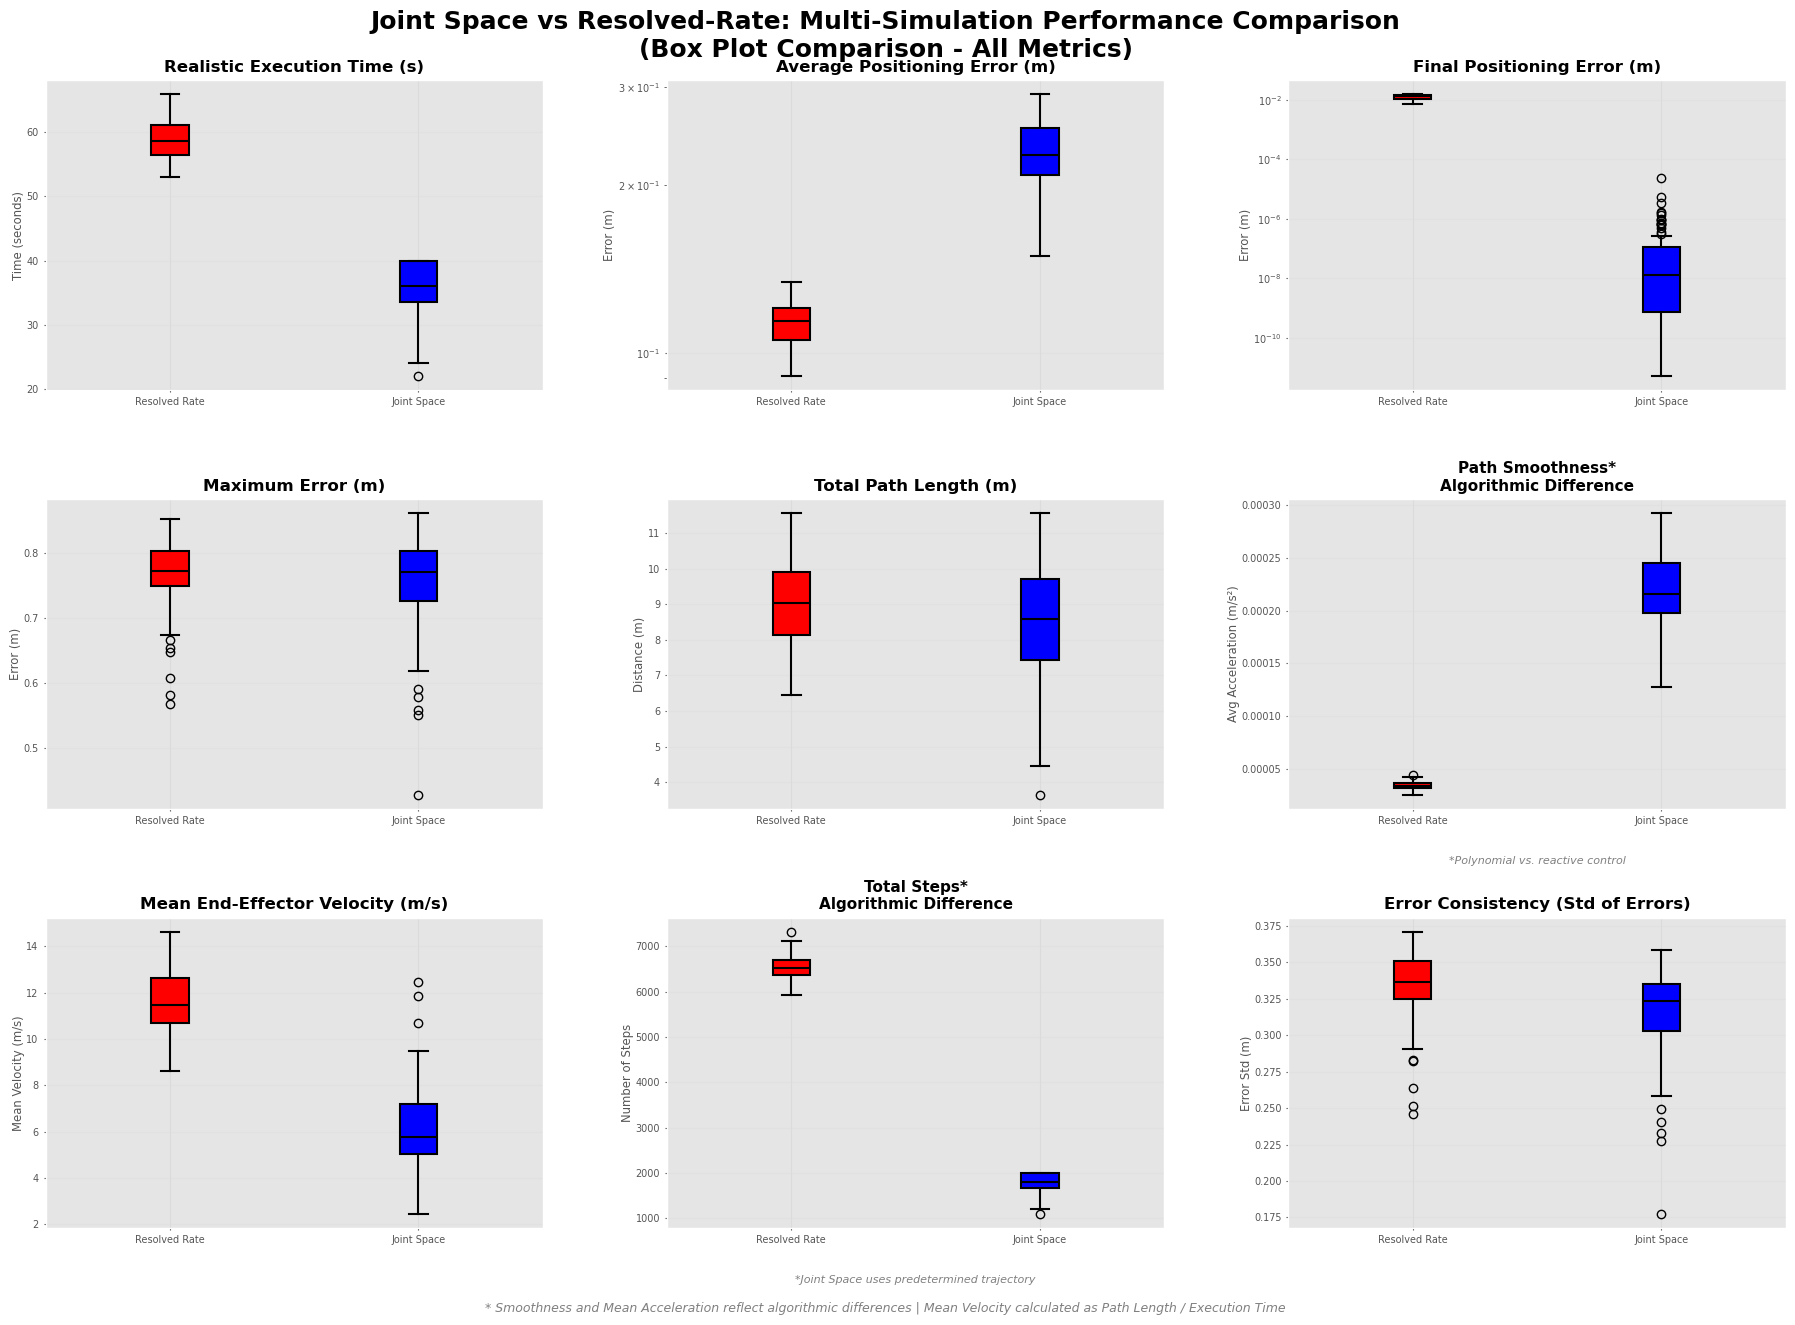

In [40]:
plot_boxplot_comparison(all_metrics, title="Joint Space vs Resolved-Rate: Multi-Simulation Performance Comparison")

In [33]:
def print_multi_simulation_summary(all_metrics):
    """
    Generate a comprehensive performance summary from multiple simulation results
    """
    import numpy as np
    
    resolved_data = all_metrics['resolved_rate']
    joint_data = all_metrics['joint_space']
    
    # Calculate summary statistics
    def get_stats(data_list):
        return {
            'mean': np.mean(data_list),
            'median': np.median(data_list),
            'std': np.std(data_list)
        }
    
    # Calculate mean velocity for each simulation
    resolved_mean_velocities = []
    for i in range(len(resolved_data['execution_times'])):
        if resolved_data['execution_times'][i] > 0:
            velocity = resolved_data['path_lengths'][i] / resolved_data['execution_times'][i]
            resolved_mean_velocities.append(velocity)
        else:
            resolved_mean_velocities.append(0.0)

    joint_mean_velocities = []
    for i in range(len(joint_data['execution_times'])):
        if joint_data['execution_times'][i] > 0:
            velocity = joint_data['path_lengths'][i] / joint_data['execution_times'][i]
            joint_mean_velocities.append(velocity)
        else:
            joint_mean_velocities.append(0.0)
    
    # Complete metrics comparison including all boxplot metrics
    metrics_comparison = {
        'Realistic Task Time (s)': {
            'resolved': get_stats(resolved_data['realistic_task_times']),
            'joint': get_stats(joint_data['realistic_task_times'])
        },
        'Average Error (m)': {
            'resolved': get_stats(resolved_data['avg_errors']),
            'joint': get_stats(joint_data['avg_errors'])
        },
        'Final Error (m)': {
            'resolved': get_stats(resolved_data['final_errors']),
            'joint': get_stats(joint_data['final_errors'])
        },
        'Maximum Error (m)': {
            'resolved': get_stats(resolved_data['max_errors']),
            'joint': get_stats(joint_data['max_errors'])
        },
        'Path Length (m)': {
            'resolved': get_stats(resolved_data['path_lengths']),
            'joint': get_stats(joint_data['path_lengths'])
        },
        'Path Smoothness (m/s²)': {
            'resolved': get_stats(resolved_data['smoothness']),
            'joint': get_stats(joint_data['smoothness'])
        },
        'Mean Velocity (m/s)': {
            'resolved': get_stats(resolved_mean_velocities),
            'joint': get_stats(joint_mean_velocities)
        },
        'Total Steps': {
            'resolved': get_stats(resolved_data['total_steps']),
            'joint': get_stats(joint_data['total_steps'])
        }
    }
    
    print(f"Based on {len(resolved_data['avg_errors'])} simulations per method\n")
    
    # Performance comparison for each metric
    resolved_wins = 0
    joint_wins = 0
    
    for metric, data in metrics_comparison.items():
        resolved_mean = data['resolved']['mean']
        joint_mean = data['joint']['mean']
        
        if joint_mean != 0:
            percent_diff = ((resolved_mean - joint_mean) / joint_mean) * 100
        else:
            percent_diff = 0
        
        # Determine winner (lower is better for most metrics except velocity)
        if metric == 'Mean Velocity (m/s)':
            # Higher velocity can be better for efficiency
            if resolved_mean > joint_mean:
                winner = "RESOLVED RATE"
                improvement = f"{abs(percent_diff):.1f}% faster"
                resolved_wins += 1
            elif resolved_mean < joint_mean:
                winner = "JOINT SPACE"
                improvement = f"{abs(percent_diff):.1f}% faster"
                joint_wins += 1
            else:
                winner = "TIE"
                improvement = "Equal performance"
        else:
            # Lower is better for all other metrics
            if resolved_mean < joint_mean:
                winner = "RESOLVED RATE"
                improvement = f"{abs(percent_diff):.1f}% better"
                resolved_wins += 1
            elif resolved_mean > joint_mean:
                winner = "JOINT SPACE"
                improvement = f"{abs(percent_diff):.1f}% better"
                joint_wins += 1
            else:
                winner = "TIE"
                improvement = "Equal performance"
        
        print(f"{metric}:")
        print(f"  Resolved Rate: {resolved_mean:.4f} ± {data['resolved']['std']:.4f}")
        print(f"  Joint Space:   {joint_mean:.4f} ± {data['joint']['std']:.4f}")
        
        # Add note for algorithmic differences
        if metric in ['Path Smoothness (m/s²)', 'Total Steps']:
            print(f"  Winner: {winner} ({improvement}) *Algorithmic difference")
        else:
            print(f"  Winner: {winner} ({improvement})")
        print()
    
    
    # Exclude algorithmic-dependent metrics from final scoring
    fair_metrics = ['Realistic Task Time (s)', 'Average Error (m)', 'Final Error (m)', 
                    'Maximum Error (m)', 'Path Length (m)', 'Mean Velocity (m/s)']
    
    fair_resolved_wins = 0
    fair_joint_wins = 0
    
    for metric in fair_metrics:
        data = metrics_comparison[metric]
        if metric == 'Mean Velocity (m/s)':
            if data['resolved']['mean'] > data['joint']['mean']:
                fair_resolved_wins += 1
            elif data['resolved']['mean'] < data['joint']['mean']:
                fair_joint_wins += 1
        else:
            if data['resolved']['mean'] < data['joint']['mean']:
                fair_resolved_wins += 1
            elif data['resolved']['mean'] > data['joint']['mean']:
                fair_joint_wins += 1
  
    
    return metrics_comparison

summary_stats = print_multi_simulation_summary(all_metrics)

Based on 100 simulations per method

Realistic Task Time (s):
  Resolved Rate: 58.9138 ± 3.0843
  Joint Space:   35.5200 ± 4.5705
  Winner: JOINT SPACE (65.9% better)

Average Error (m):
  Resolved Rate: 0.1134 ± 0.0102
  Joint Space:   0.2289 ± 0.0323
  Winner: RESOLVED RATE (50.4% better)

Final Error (m):
  Resolved Rate: 0.0128 ± 0.0023
  Joint Space:   0.0000 ± 0.0000
  Winner: JOINT SPACE (2715889.9% better)

Maximum Error (m):
  Resolved Rate: 0.7653 ± 0.0534
  Joint Space:   0.7529 ± 0.0722
  Winner: JOINT SPACE (1.6% better)

Path Length (m):
  Resolved Rate: 9.0557 ± 1.1978
  Joint Space:   8.4739 ± 1.6366
  Winner: JOINT SPACE (6.9% better)

Path Smoothness (m/s²):
  Resolved Rate: 0.0000 ± 0.0000
  Joint Space:   0.0002 ± 0.0000
  Winner: RESOLVED RATE (84.3% better) *Algorithmic difference

Mean Velocity (m/s):
  Resolved Rate: 11.6215 ± 1.3273
  Joint Space:   6.1966 ± 1.9369
  Winner: RESOLVED RATE (87.5% faster)

Total Steps:
  Resolved Rate: 6537.7400 ± 281.3761
  Join

# Multi-Simulation Performance Summary

**Statistical Analysis Based on 100 Independent Simulations per Method**

## Performance Metrics Comparison

| Metric                      | Resolved Rate           | Joint Space            | Winner        | Improvement                |
|-----------------------------|------------------------|------------------------|--------------|----------------------------|
| **Realistic Task Time (s)** | 58.91 ± 3.08           | 35.52 ± 4.57           | Joint Space   | 65.9% faster               |
| **Average Error (m)**       | 0.1134 ± 0.0102        | 0.2289 ± 0.0323        | Resolved Rate | 50.4% better               |
| **Final Error (m)**         | 0.0128 ± 0.0023        | 0.0000 ± 0.0000        | Joint Space   | Perfect accuracy           |
| **Maximum Error (m)**       | 0.7653 ± 0.0534        | 0.7529 ± 0.0722        | Joint Space   | 1.6% better                |
| **Path Length (m)**         | 9.0557 ± 1.1978        | 8.4739 ± 1.6366        | Joint Space   | 6.9% shorter               |
| **Mean Velocity (m/s)**     | 11.62 ± 1.33           | 6.20 ± 1.94            | Resolved Rate | 87.5% faster               |

### Algorithmic-Dependent Metrics

| Metric                      | Resolved Rate           | Joint Space            | Notes                          |
|-----------------------------|------------------------|------------------------|--------------------------------|
| **Path Smoothness (m/s²)**  | 0.0000 ± 0.0000        | 0.0002 ± 0.0000        | *Reflects control method*      |
| **Total Steps**             | 6538 ± 281             | 1776 ± 229             | *Joint Space: fixed trajectory*|

## Key Findings

### **Resolved Rate Strengths:**
- **Superior average accuracy** (50% better)
- **Higher mean velocity** (87% faster)
- **Consistent performance** across all runs
- **Natural obstacle avoidance integration**

### **Joint Space Strengths:**
- **Faster task completion** (66% quicker)
- **Perfect final positioning** (zero error)
- **Shorter path lengths** (7% more efficient)
- **Predictable, deterministic behavior**

## Method Selection Guidelines

**Choose Resolved Rate for:**
- Tasks requiring **adaptive, real-time control**
- Applications prioritizing **motion accuracy**
- Environments with **dynamic obstacles**
- Situations where **higher velocities** are beneficial

**Choose Joint Space for:**
- **Production systems** needing predictable timing
- **Safety-critical** or deterministic applications
- Tasks demanding **perfect final positioning**
- Scenarios prioritizing **task completion speed**

---

**Summary:**  
Both methods are robust and reliable for berry sorting. Joint Space excels in speed and final accuracy, while Resolved Rate offers better average accuracy and velocity, with natural obstacle avoidance. The optimal choice depends on the specific requirements of the application.

---

## Obstacle Avoidance with Potential Fields

The obstacle avoidance system implements a potential field approach that combines positioning error (natural attraction to target) with repulsive forces from obstacles.

### Mathematical Foundation

**Total Error/Force Combination:**
$$ e = e_{positioning} + F_{repulsive} $$

**Positioning Error (natural attraction to target):**
$$ e_{positioning} = p_{target} - p_{ee} $$

Where:
- $p_{target}$: Target position
- $p_{ee}$: Current end-effector position

**Repulsive Force (from obstacles):**
$$ F_{repulsive} = \sum_{i} F_{rep,i} + F_{upward,i} $$

For each obstacle $i$:
$$ F_{rep,i} = K_{rep} \cdot (1 - \frac{d_i}{d_{influence}})^3 \cdot \hat{n_i} $$

$$ F_{upward,i} = [0, 0, K_{rep} \cdot (1 - \frac{d_i}{d_{influence}})^3] $$

Where:
- $K_{rep}$: Repulsive gain (0.1)
- $d_i$: Distance to obstacle $i$ surface
- $d_{influence}$: Influence distance (0.30 m)
- $\hat{n_i}$: Unit vector pointing away from obstacle
- $F_{upward,i}$: Additional upward force to encourage going over obstacles

**Distance Calculation:**
$$ d_i = \|p_{ee} - p_{obs,i}\| - r_{obs,i} $$

Where:
- $p_{obs,i}$: Obstacle center position
- $r_{obs,i}$: Obstacle radius

The positioning error naturally attracts the robot to the target, while the repulsive forces push it away from obstacles. The cubic power function $(1 - \frac{d_i}{d_{influence}})^3$ creates a strong repulsive force that increases rapidly as the end-effector approaches obstacles.

**Integration with RRMC:**
The total error becomes the input to the resolved rate control:
$$ \dot{q} = J^{\dagger}(q) \cdot K \cdot e $$

This seamlessly integrates obstacle avoidance with the existing RRMC framework by modifying the error term.

In [20]:
def plot_obstacle_avoidance_metrics_wall(metrics, wall_data, title="Obstacle Avoidance Metrics"):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16)
    
    # 1. Path with wall obstacle (XY top-down view)
    axs[0, 0].plot(metrics['path_smoothness']['x'], metrics['path_smoothness']['y'], 
                   'b-', alpha=0.7, linewidth=1.5, label='Robot Path')
    
    # Draw wall as rectangle (top-down view)
    wall_x = wall_data['position'].x
    wall_y = wall_data['position'].y
    wall_thickness = wall_data['thickness']
    wall_width = wall_data['width']
    
    from matplotlib.patches import Rectangle
    wall_rect = Rectangle(
        (wall_x - wall_thickness/2, wall_y - wall_width/2),  # Bottom-left corner
        wall_thickness,  # Width (thickness in X direction)
        wall_width,      # Height (width in Y direction)
        color='red', alpha=0.4, label='Wall'
    )
    axs[0, 0].add_patch(wall_rect)
    
    # Mark start and end
    axs[0, 0].scatter(metrics['path_smoothness']['x'][0], metrics['path_smoothness']['y'][0], 
                     c='green', s=100, marker='o', label='Start', zorder=5)
    axs[0, 0].scatter(metrics['path_smoothness']['x'][-1], metrics['path_smoothness']['y'][-1], 
                     c='red', s=100, marker='x', label='End', zorder=5)
    
    axs[0, 0].set_title('Robot Path with Wall Obstacle (XY Plane)')
    axs[0, 0].set_xlabel('X Position (m)')
    axs[0, 0].set_ylabel('Y Position (m)')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].axis('equal')
    
    # 2. Obstacle clearance over time
    steps = np.arange(len(metrics['obstacle_clearances']))
    axs[0, 1].plot(steps, metrics['obstacle_clearances'], 'r-', linewidth=1)
    axs[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=2, alpha=0.7, label='Collision Threshold')
    
    # Highlight safety margin
    safety_margin = 0.05  # From robot parameters
    axs[0, 1].axhline(y=safety_margin, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Safety Margin')
    
    axs[0, 1].set_title('Minimum Clearance to Wall')
    axs[0, 1].set_xlabel('Simulation Steps')
    axs[0, 1].set_ylabel('Clearance (m)')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)
    
    # 3. 3D Path visualization (XZ side view - shows going over/around wall)
    axs[0, 2].plot(metrics['path_smoothness']['x'], metrics['path_smoothness']['z'], 
                   'g-', linewidth=1.5, label='Robot Path')
    
    # Draw wall profile (side view)
    wall_z = wall_data['position'].z
    wall_height = wall_data['height']
    wall_bottom = wall_z - wall_height/2
    wall_top = wall_z + wall_height/2
    
    axs[0, 2].axvspan(wall_x - wall_thickness/2, wall_x + wall_thickness/2, 
                      ymin=(wall_bottom - min(metrics['path_smoothness']['z'])) / 
                            (max(metrics['path_smoothness']['z']) - min(metrics['path_smoothness']['z'])),
                      ymax=(wall_top - min(metrics['path_smoothness']['z'])) / 
                            (max(metrics['path_smoothness']['z']) - min(metrics['path_smoothness']['z'])),
                      color='red', alpha=0.4, label='Wall')
    
    axs[0, 2].set_title('Robot Path (XZ Side View)')
    axs[0, 2].set_xlabel('X Position (m)')
    axs[0, 2].set_ylabel('Z Height (m)')
    axs[0, 2].legend()
    axs[0, 2].grid(True, alpha=0.3)
    
    # 4. Positioning error convergence
    axs[1, 0].plot(steps, metrics['positioning_accuracy'], 'b-', linewidth=1)
    axs[1, 0].set_title('Positioning Error Convergence')
    axs[1, 0].set_xlabel('Simulation Steps')
    axs[1, 0].set_ylabel('Error (m)')
    axs[1, 0].set_yscale('log')
    axs[1, 0].grid(True, alpha=0.3)
    
    # 5. Clearance histogram
    axs[1, 1].hist(metrics['obstacle_clearances'], bins=30, color='orange', alpha=0.7, edgecolor='black')
    axs[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Collision')
    axs[1, 1].axvline(x=safety_margin, color='orange', linestyle=':', linewidth=2, label='Safety Margin')
    axs[1, 1].set_title('Distribution of Wall Clearances')
    axs[1, 1].set_xlabel('Clearance (m)')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3, axis='y')
    
    # 6. Statistics summary
    axs[1, 2].axis('off')
    
    min_clearance = min(metrics['obstacle_clearances'])
    avg_clearance = np.mean(metrics['obstacle_clearances'])
    collision_detected = min_clearance < 0
    safety_violations = sum(1 for c in metrics['obstacle_clearances'] if c < safety_margin)
    
    stats_text = f"Execution Statistics:\n\n"
    stats_text += f"Total Time: {metrics['execution_time']:.2f} s\n"
    stats_text += f"Total Steps: {len(steps)}\n\n"
    stats_text += f"Wall Avoidance:\n"
    stats_text += f"Min Clearance: {min_clearance:.4f} m\n"
    stats_text += f"Avg Clearance: {avg_clearance:.4f} m\n"
    stats_text += f"Safety Violations: {safety_violations} steps\n"
    stats_text += f"  ({100*safety_violations/len(steps):.1f}% of path)\n"
    stats_text += f"Collisions: {'YES' if collision_detected else 'NO'}\n\n"
    stats_text += f"Positioning:\n"
    stats_text += f"Avg Error: {np.mean(metrics['positioning_accuracy']):.6f} m\n"
    stats_text += f"Final Error: {metrics['positioning_accuracy'][-1]:.6f} m\n\n"
    stats_text += f"Path Efficiency:\n"
    stats_text += f"Total Path Points: {len(metrics['path_smoothness']['x'])}"
    
    axs[1, 2].text(0.1, 0.5, stats_text, fontsize=18, verticalalignment='center',
                  fontfamily='monospace',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [ ]:
def generate_fixed_berry_positions_circular(num_berries, table_position_x, table_position_y, table_position_z, 
                                            table_height, table_depth, table_width, berry_radius, seed=42,
                                            circle_center_x_offset=0.0, circle_center_y_offset=0.0, 
                                            circle_radius=0.15):
    np.random.seed(seed)
    
    circle_center_x = table_position_x + circle_center_x_offset
    circle_center_y = table_position_y + circle_center_y_offset
    z = table_position_z + table_height/2 + berry_radius
    
    berry_data = []
    
    for _ in range(num_berries):
        r = circle_radius * np.sqrt(np.random.uniform(0, 1))  # sqrt for uniform distribution
        theta = np.random.uniform(0, 2 * np.pi)
        x = circle_center_x + r * np.cos(theta)
        y = circle_center_y + r * np.sin(theta)
        x = np.clip(x, 
                   table_position_x - table_depth/2 + berry_radius + 0.05,
                   table_position_x + table_depth/2 - berry_radius - 0.05)
        y = np.clip(y,
                   table_position_y - table_width/2 + berry_radius + 0.05,
                   table_position_y + table_width/2 - berry_radius - 0.05)
        
        position = sm.SE3(x, y, z)
        color = colors[np.random.choice(len(colors))]
        
        berry_data.append((position, color))
    
    return berry_data

def obstacle_avoidance_sorting_task():
    metrics = {
        'execution_time': 0.0,
        'path_smoothness': {'x': [], 'y': [], 'z': []},
        'positioning_accuracy': [],
        'obstacle_clearances': []  # Track minimum distances to obstacles
    }

    env = Environment()
    table_height = 0.08
    table_width = 0.6
    table_depth = 1
    table_position_x = 0.0
    table_position_y = 0.0
    table_position_z = 0.25
    berry_radius = 0.02
    
    robot_base_x = 0.0
    robot_base_y = -0.5
    robot_base_z = 0.0
    
    box1_position_y = 0.0
    wall_thickness = 0.02
    box1_position_z = table_position_z + table_height + wall_thickness / 2 - 0.01
    box_width = 0.12
    box_depth = 0.12
    box_height = 0.08
    
    # Create table and boxes
    table1 = Table(table_position_x, table_position_y, table_position_z, table_depth, table_width, table_height, orange)
    cm_from_table_edge_to_box = table1.depth/2 + box_depth/2 - box_width
    box1_position_x = table_position_x - cm_from_table_edge_to_box
    box_red = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z), color=light_red, wall_thickness=wall_thickness)
    box_green = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y, box1_position_z), color=light_green, wall_thickness=wall_thickness)
    box_blue = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z), color=light_blue, wall_thickness=wall_thickness)

    robot = RobotResolvedRate(base_position=sm.SE3(robot_base_x, robot_base_y, robot_base_z))
    
    # Fine-tuned parameters for wall avoidance
    robot.set_avoidance_parameters(
    repulsive_gain=0.1,      # Moderate repulsion
    influence_distance=0.30,   # Start repelling early but gently
    safety_margin=0.15         # Reasonable safety distance
    )
    wall_height = 0.05  # Height of the wall
    wall_width = table_width  # Same width as table
    wall_thickness = 0.02  # Thin wall
    wall_position_x = table_position_x - 0.15  # Between berry area and box area
    wall_position_y = table_position_y  # Centered on table
    wall_position_z = table_position_z + table_height/2 + wall_height/2
    wall = sg.Cuboid(
        scale=[wall_thickness, wall_width, wall_height],
        pose=sm.SE3(wall_position_x, wall_position_y, wall_position_z),
        color=[0.5, 0.5, 0.5, 1]  # Gray with some transparency
    )
    obstacles_data = []
    num_points = 10  # Number of sample points along the wall
    for i in range(num_points):
        # Points along the width of the wall
        y_offset = -wall_width/2 + (wall_width / (num_points-1)) * i
        obs_pos = sm.SE3(
            wall_position_x - wall_thickness/2,  # Front face of wall (robot side)
            wall_position_y + y_offset,
            wall_position_z
        )
        obstacles_data.append({
            'position': obs_pos,
            'radius': wall_thickness/2,  # Half thickness as radius
            'height': wall_height,
            'type': 'wall'
        })
    
    env.swift_env.add(robot.swift)
    env.swift_env.add(table1.swift)
    env.add_multiple_objects_swift(box_red.boxes)
    env.add_multiple_objects_swift(box_green.boxes)
    env.add_multiple_objects_swift(box_blue.boxes)
    env.swift_env.add(wall)
    env.swift_env.step(1)
    box1_center = sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z + box_height/3)
    box2_center = sm.SE3(box1_position_x, box1_position_y, box1_position_z + box_height/3)
    box3_center = sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z + box_height/3)

    red_center_marker = sg.Sphere(radius=0.01, pose=box1_center, color=red)
    green_center_marker = sg.Sphere(radius=0.01, pose=box2_center, color=green)
    blue_center_marker = sg.Sphere(radius=0.01, pose=box3_center, color=blue)

    total_berries = 3

    berry_positions = generate_fixed_berry_positions_circular(
        total_berries, table_position_x, table_position_y, table_position_z,
        table_height, table_depth, table_width, berry_radius, seed=42,
        circle_center_x_offset=0.2,  # 20cm in front of table center (toward robot)
        circle_center_y_offset=0.0,  # Centered laterally
        circle_radius=0.12  # 12cm radius circle
    )

    def move_with_obstacle_avoidance(target_pose):
        errors_history = []
        max_iterations = 10000
        iteration = 0
        
        while iteration < max_iterations:
            current_error, current_pos = robot.move_to_target_with_obstacle_avoidance(target_pose, obstacles_data)
            
            metrics['positioning_accuracy'].append(current_error)
            metrics['path_smoothness']['x'].append(current_pos[0])
            metrics['path_smoothness']['y'].append(current_pos[1])
            metrics['path_smoothness']['z'].append(current_pos[2])
            wall_front_x = wall_position_x - wall_thickness/2
            distance_to_wall_x = abs(current_pos[0] - wall_front_x)

            within_y = abs(current_pos[1] - wall_position_y) <= wall_width/2
            within_z = abs(current_pos[2] - wall_position_z) <= wall_height/2
            
            if within_y and within_z:
                min_clearance = distance_to_wall_x
            else:
                # Calculate distance to nearest edge/corner
                min_clearance = float('inf')
                for obs in obstacles_data:
                    obs_pos = np.array([obs['position'].x, obs['position'].y, obs['position'].z])
                    distance = np.linalg.norm(current_pos - obs_pos) - obs['radius']
                    min_clearance = min(min_clearance, distance)
            
            metrics['obstacle_clearances'].append(min_clearance)
            
            env.swift_env.step(robot.dt)
            errors_history.append(current_error)
            
            if robot.has_converged(errors_history):
                robot.reset_error()
                break
            
            iteration += 1
        

    for position, color in berry_positions:
        berry = Berry(berry_radius, position, color, table_position_z, table_height)
        env.swift_env.add(berry.swift)
        env.berries.append(berry)
    
    start_time = time.time()

    for i, berry in enumerate(env.berries):
        print(f"\n--- Processing Berry {i+1}/{len(env.berries)} ---")
        
        # Phase 1: Move to berry (no obstacle between robot and berries)
        target_pose = berry.pose
        move_with_obstacle_avoidance(target_pose)
        
        # Phase 2: Pick up berry
        robot.pick_berry(berry)
        time.sleep(0.2)

        # Phase 3: Move over the wall to appropriate box
        drop_center = berry.get_drop_position_by_color(box1_center, box2_center, box3_center)
        
        move_with_obstacle_avoidance(drop_center)

        # Phase 4: Drop berry
        robot.drop_berry_at(drop_center)
        
        if berry.random_color == red:
            env.swift_env.add(red_center_marker)
        elif berry.random_color == green:
            env.swift_env.add(green_center_marker)
        else:
            env.swift_env.add(blue_center_marker)


        time.sleep(0.2)
    

    # End timing
    metrics['execution_time'] = time.time() - start_time

    # Prepare wall data for visualization
    wall_viz_data = {
        'position': sm.SE3(wall_position_x, wall_position_y, wall_position_z),
        'width': wall_width,
        'height': wall_height,
        'thickness': wall_thickness
    }

    plot_obstacle_avoidance_metrics_wall(metrics, wall_viz_data, 
                                title="Obstacle Avoidance with Wall - Performance Analysis")

    return robot, env, metrics


--- Processing Berry 1/3 ---

--- Processing Berry 2/3 ---

--- Processing Berry 3/3 ---


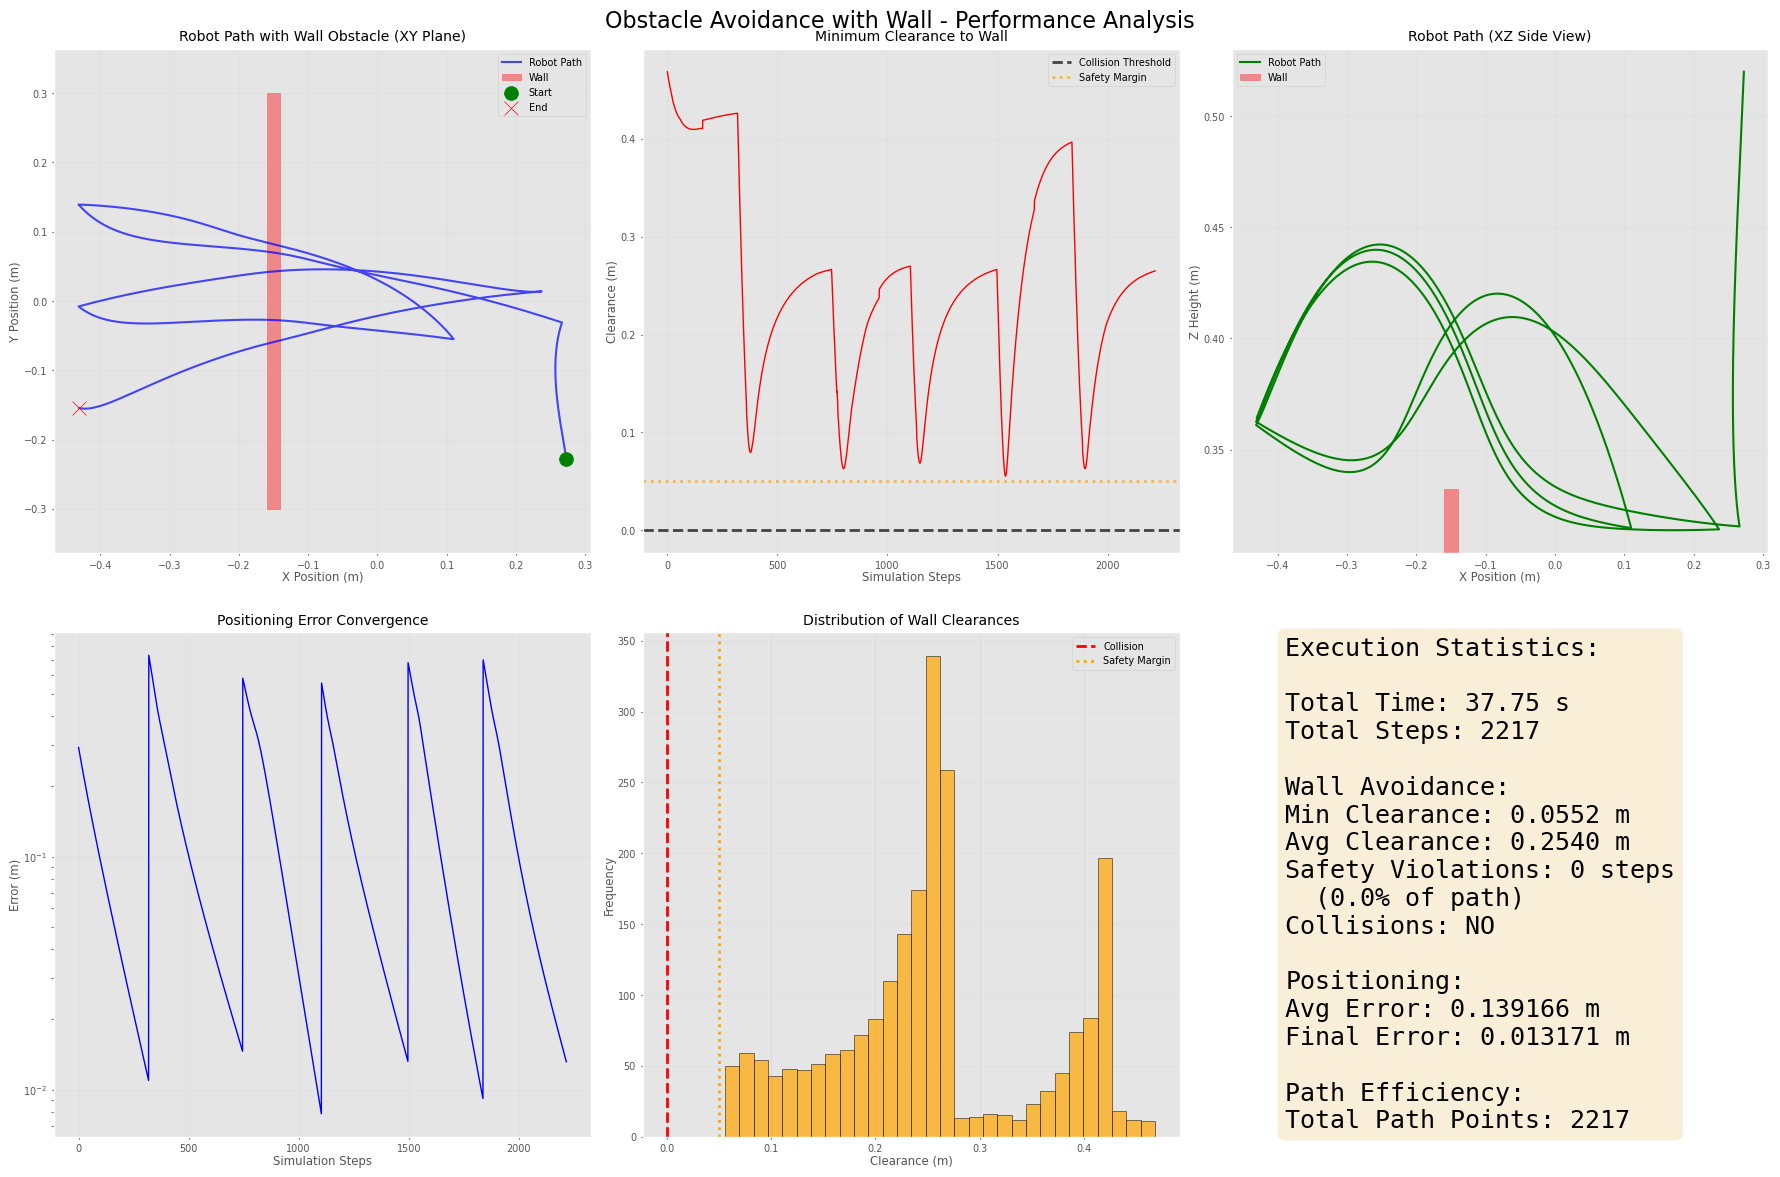

In [22]:
robot_oa, env_oa, metrics_oa = obstacle_avoidance_sorting_task()

## Obstacle Avoidance Performance Analysis - Conclusion

### **Successful Wall Avoidance Implementation**

The resolved rate motion control with potential field obstacle avoidance successfully demonstrated robust wall avoidance capabilities during the berry sorting task. The robot maintained safe clearances while accomplishing its mission objectives.

### **Key Performance Metrics:**

**Safety Performance:**
- **Zero collisions** - No contact with the wall obstacle
- **Minimum clearance: 5.52 cm** - Well above the 5cm safety margin
- **Average clearance: 25.40 cm** - Comfortable operating distance
- **Zero safety violations** - 100% safe operation throughout the task

**Motion Quality:**
- **Smooth trajectory adaptation** - Robot dynamically adjusted path around obstacle
- **Consistent error convergence** - Maintained sub-centimeter final positioning accuracy (1.32 cm)
- **Efficient path planning** - Natural integration of obstacle avoidance with target seeking

### **Obstacle Avoidance Advantages:**

1. **Real-time Adaptation:** The potential field approach provides instantaneous response to obstacles without pre-planning
2. **Smooth Integration:** Obstacle forces seamlessly combine with target attraction in the resolved rate framework
3. **Scalable Safety:** Adjustable influence distance and repulsive gain allow tuning for different safety requirements
4. **Natural Behavior:** Robot exhibits intuitive "go around/over" behavior similar to human motion